In [2]:
# Import python packages that are used here
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob
import cmath as cm
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from glob import glob
from matplotlib.pyplot import figure
import os
import sys

# Append the path where the function.py is.
sys.path.append(os.path.abspath(r"/Users/itungchen/Publications/BGaP_Charac_AOFS/"))

# Import `functions.py` to help us to import measured data

from functions import import_pol_data
from functions import import_lin_data
from functions import import_TD_data
from functions import Do_the_thing

In [3]:
root_path = r'/Users/itungchen/UW_lab_data/'
DL_dir_name =  root_path + '/20230424-SOS-DL//'

# Define the sort function of the frequency domain data
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[4:-12])

file_name = ['35K-*-S11-pol.prn', '35K-*-S12-pol.prn', '35K-*-S21-pol.prn', '35K-*-S22-pol.prn']

# Grab file name and store in DL list
DL_4K_S11 = glob(DL_dir_name + '35K-*-S11-pol.prn')
DL_4K_S11.sort(key = sortKeyFunc_FD)
DL_4K_S22 = glob(DL_dir_name + '35K-*-S22-pol.prn')
DL_4K_S22.sort(key = sortKeyFunc_FD)
DL_4K_S12 = glob(DL_dir_name + '35K-*-S12-pol.prn')
DL_4K_S12.sort(key = sortKeyFunc_FD)
DL_4K_S21 = glob(DL_dir_name + '35K-*-S21-pol.prn')
DL_4K_S21.sort(key = sortKeyFunc_FD)

# Import frequency domain data
S11_list_4K = []
S22_list_4K = []
S12_list_4K = []
S21_list_4K = []

for fn_11, fn_12, fn_21, fn_22 in zip(DL_4K_S11, DL_4K_S12, DL_4K_S21, DL_4K_S22):
    freq11, r11, i11 = import_pol_data(fn_11)
    freq12, r12, i12 = import_pol_data(fn_12)
    freq21, r21, i21 = import_pol_data(fn_21)
    freq22, r22, i22 = import_pol_data(fn_22)
    
    S11_list_4K.append(r11 + 1j*i11)
    S12_list_4K.append(r12 + 1j*i12)
    S21_list_4K.append(r21 + 1j*i21)
    S22_list_4K.append(r22 + 1j*i22)
    

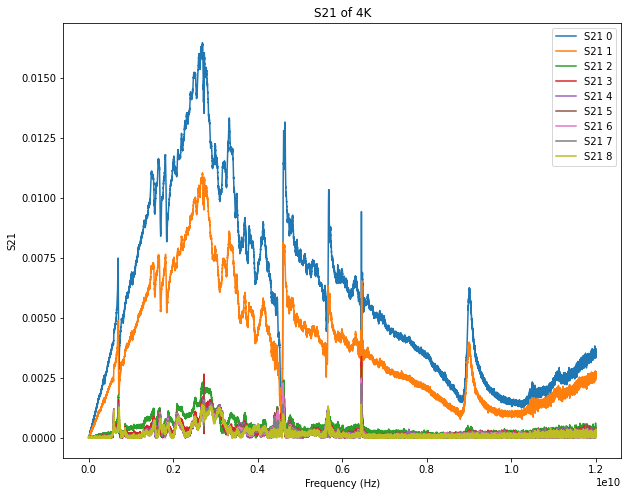

In [4]:
# Plot all the S21 data in 4K in one plot
fig, ax = plt.subplots(1,1, figsize=(10, 8))
for i in range(len(S21_list_4K)):
    ax.plot(freq21, np.abs(S21_list_4K[i]), label = 'S21 ' + str(i))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('S21')
ax.set_title('S21 of 4K')
ax.legend()


# Fourier transform
The S21 data and plot the time domain data.

        L_delay = [30, 45, 70, 100, 140, 650, 950, 1400, 2000, 3020, 4300, 4600] # in um
        T_list = [4, 7, 13.9, 30, 40, 60, 95, 140, 210, 300]




In [5]:
import scipy.fft

def ifft_complex_data(cmpl_s21, freq, print_time_reso = True):
    # import the data
    N_pts = len(cmpl_s21)

    # Perform ifft on the imported data
    s21_ift = scipy.fft.ifft(cmpl_s21)

    # Calculate the time resolution
    t_reso = 1/((freq[-1]-freq[0]))
    
    if print_time_reso:
        print('Time resolution is:', t_reso, 'nano sec')

    # The time here inclued the flipped data
    t_span = np.array(range(N_pts))*t_reso #s

    return N_pts, s21_ift, t_span, t_reso

In [6]:
ifft_list_4K = []
for cmpl_s21 in S21_list_4K:
    N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq21, print_time_reso = False)
    ifft_list_4K.append(s21_ift)


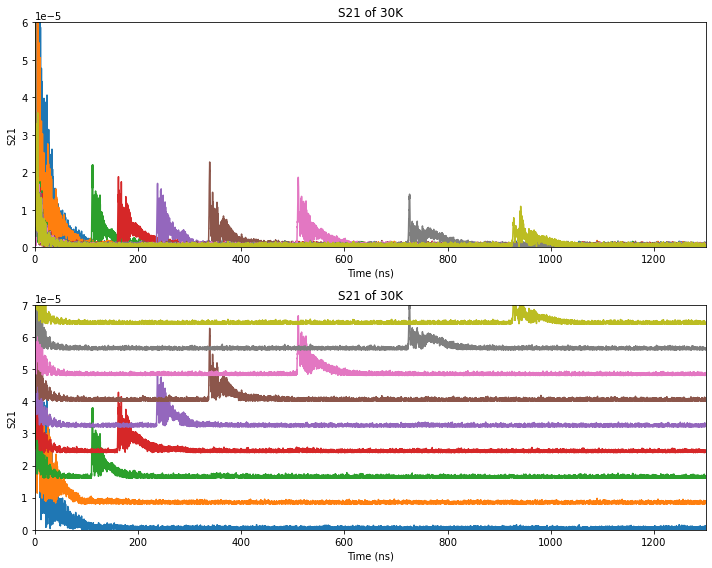

In [7]:
# Plot two plots: one is the time domain with a larger time span, the other is the time domain with a smaller time span and smaller y limit
fig, ax = plt.subplots(2,1, figsize=(10, 8))
for i in range(len(ifft_list_4K)):
    ax[0].plot(t_span/1e-9, np.abs(ifft_list_4K[i]), label = 'S21 ' + str(i))
    ax[1].plot(t_span/1e-9, np.abs(ifft_list_4K[i]) + 0.8e-5*i, label = 'S21 ' + str(i))

ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('S21')
ax[0].set_title('S21 of 30K')
ax[0].set_xlim(0, 1300)
ax[0].set_ylim(0, 6e-5)
#ax[0].legend()

ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('S21')
ax[1].set_title('S21 of 30K')
#ax[1].legend()
ax[1].set_xlim(0, 1300)
ax[1].set_ylim(0, 7e-5)

plt.tight_layout()

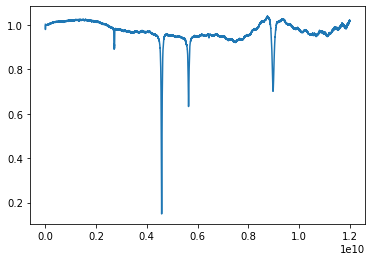

In [8]:
plt.plot(freq21, np.abs(S11_list_4K[1]), label = 'S21 ' + str(i))


# Time Gating
This is the list that stores the ifft data, and the time span of the data.

        ifft_list_4K, t_span

Now we will try to time gate the data and trasform back to look at the S21 in frequenct domain using the function 

        Filter_S21_singnals

In [12]:
from S21Gating import Filter_S21_signals

time_gated_FD_list_4K = []
for ifft_data in ifft_list_4K:
    _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq21, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = True,
                                                                                    filter_peaks = False,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = True,
                                                                                    t_noise=[10], expand_noise = 0.1,
                                                                                    t_peaks=[0], expand_peaks = 200,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 1300,
                                                                                    xmax=1000, ymax=1000e-6, ymax_fdom = 10e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = False)

    time_gated_FD_list_4K.append(nor_cmpl_filtered)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...


Filtering(1) noise...


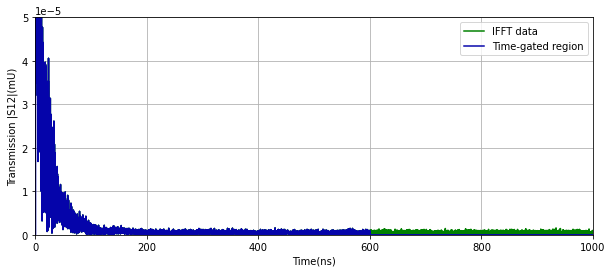

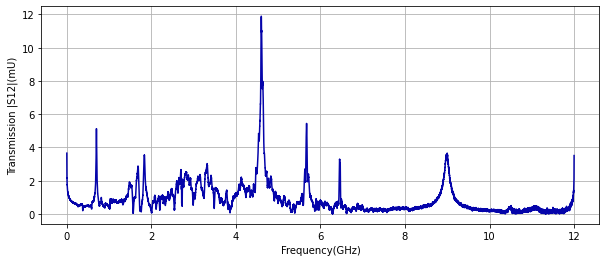

In [36]:
_, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq21, 
                                                                                ifft_list_4K[0], 
                                                                                t_reso,   
                                                                                N_pts = N_pts,  
                                                                                filter_noise = True,
                                                                                filter_peaks = False,
                                                                                filter_picking = False, 
                                                                                filter_stop = True,
                                                                                t_noise=[1], expand_noise = 0.1,
                                                                                t_peaks=[600, 800], expand_peaks = 50,
                                                                                t_picked = [350], expand_picked = 100,
                                                                                t_stop = 600,
                                                                                xmax=1000, ymax=500e-7, ymax_fdom = 10e-5, manual_scale= False,
                                                                                savefig = False,
                                                                                plot_filtering = True)

[0.004153337977555474, 0.003062049667865312, 0.0020787234829076815, 0.001761467118572539, 0.0017813521708585549, 0.0017596112408265088, 0.0023217087886941204, 0.0013720839297933997, 0.0009737232161506463]


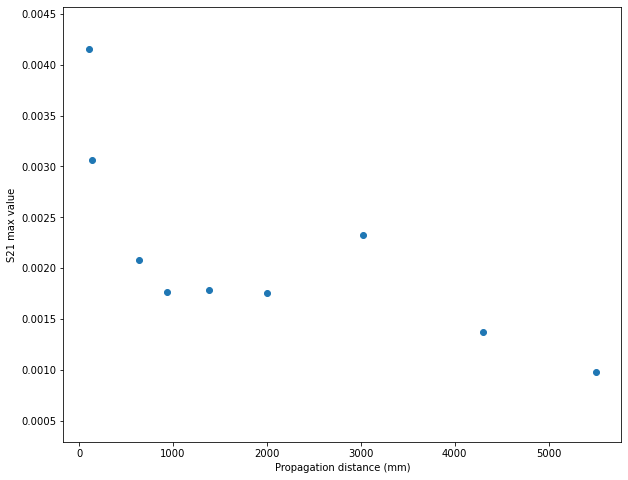

In [10]:
# Search for the index between 7GHz and 8GHz
start = 4e9 #Hz
end = 5e9 #Hz

# Find the indices of the range in xdata
start_idx = np.argmin(np.abs(freq21 - start))
end_idx = np.argmin(np.abs(freq21 - end))

# Find the maximum value between the two indices
S21_max_list_4K = []
for time_gated_data in time_gated_FD_list_4K:
    Max_value = np.max(np.abs(time_gated_data[start_idx:end_idx]))
    S21_max_list_4K.append(Max_value)

# Plot the S21 max values
prop_distance =  [102, 141 ,643, 935, 1385, 2000, 3025, 4305, 5505]

fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list_4K, 'o')
ax.set_xlabel('Propagation distance (mm)')
ax.set_ylabel('S21 max value')

# Set y limit
ax.set_ylim(S21_max_list_4K[-1]*0.3, S21_max_list_4K[0]*1.1)

print(S21_max_list_4K)

Text(0.25, 0.9, '$\\alpha = $1.016 dB/mm')

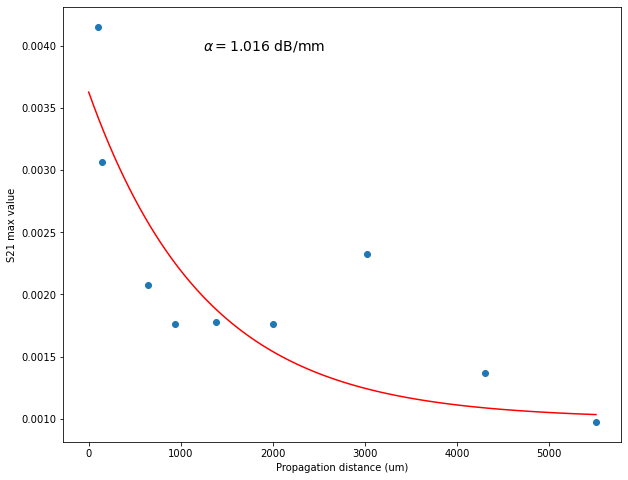

In [11]:
# Fit the data with a exponential decay function with decay constant
def exp_decay(x, b, alpha):
    return b*np.exp(-alpha*(x-165e-3)) + 0.001

popt, pcov = curve_fit(exp_decay, np.array(prop_distance)*1e-3, np.array(S21_max_list_4K), p0=[0.06, 0.1])

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, np.array(S21_max_list_4K), 'o')
x_fit = np.linspace(0, prop_distance[-1], 100)

ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *popt), 'r-')
ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(-10*np.log10(popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)

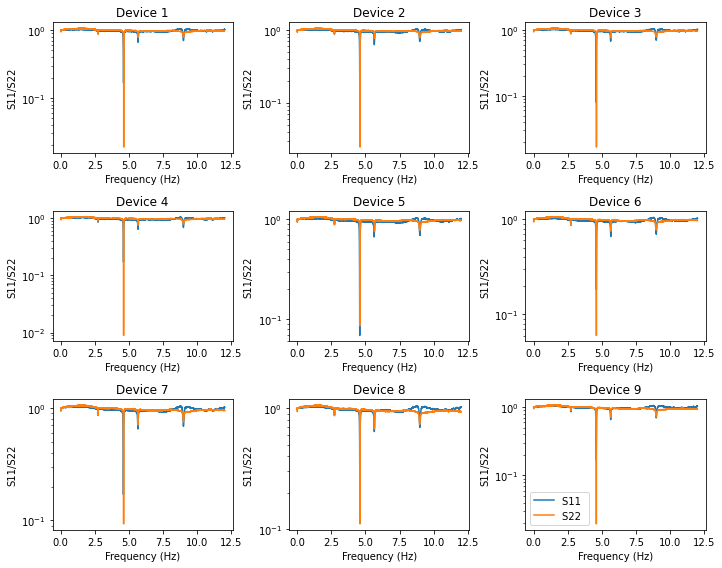

In [12]:
# Try to correct the IDT efficiency. Assuming the IDT efficiency is similar for all devices except deivce 6,7,8
# Plot a figure with 4 by 3 subplots
fig, ax = plt.subplots(3,3, figsize=(10, 8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(freq11/1e9, np.abs(S11_list_4K[i*3+j]), label = 'S11 ' )
        ax[i,j].plot(freq11/1e9, np.abs(S22_list_4K[i*3+j]), label = 'S22 ' )
        ax[i,j].set_xlabel('Frequency (Hz)')
        ax[i,j].set_ylabel('S11/S22')
        ax[i,j].title.set_text('Device '+str(i*3+j+1))
        ax[i,j].set_yscale('log')
        #ax[i,j].set_xlim(7e9, 8e9)
        #ax[i,j].set_ylim(0, 0.00055)
ax[i,j].legend()

plt.tight_layout()

# SOS 30K dry chamber data

In [14]:
def hstack_BVD_for_fit(Z):
    return np.hstack((Z.real, Z.imag))

# Convert the S11 data to impedance
def convert_s11_to_impedance(s11_pol):
    s11_pol = np.array(s11_pol)
    imp_pol = 50*(1+s11_pol)/(1-s11_pol)
    return imp_pol

# Covert the fitted load to S11 data
def convert_imped_to_s11(impedance):
    impedance = np.array(impedance)
    s11_pol = (impedance-50)/(impedance+50)
    return s11_pol

# Modified BVD model excluding the admittance Ya(omega) but including the series inductive lump elements
def modified_BVD_model_Exclude_Ya_4K(freq, L0, Rs, R0, C0):
    C0 = C0*1e-9
    L0 = L0*1e-9
    jOmega = 1j*2*np.pi*np.array(freq)
    Z0 =  1/(jOmega*C0 + 1/R0)
    return jOmega*L0 + Rs + Z0
# Modified BVD model's admittance part

def modified_BVD_model(freq, Lm, Cm, Rm):
     
    # Convert the unit to SI unit 
    Cm = Cm*1e-14 #F
    Lm = Lm*1e-9 #H
    
    # Calculate the angular frequency
    Omega = 2*np.pi*np.array(freq) #Rad
    ws = 1/np.sqrt(Lm*Cm) #Rad/s

    # Calculate the admittance Ya
    Y = ( Rm * (Omega * Cm)** 2 - 1j * Omega * Cm * ( (Omega/ws)**2 - 1) )/ ( (Rm * Omega * Cm)**2 + ((Omega/ws)**2 - 1)**2 )
    return Y # Is a complex number

def fit_BVD_model_background_4K(freq, Impedance_data, start1, end1, start2, end2, p0, bounds, ftol, max_nfev,
                                
                                print_params = True):

    # Find the indices of the range in xdata
    start_idx1 = np.argmin(np.abs(freq - start1))
    end_idx1 = np.argmin(np.abs(freq - end1))
    start_idx2 = np.argmin(np.abs(freq - start2))
    end_idx2 = np.argmin(np.abs(freq - end2))

    # Slice xdata and ydata to the two specified ranges and concatenate them
    x_fit = np.concatenate((freq[start_idx1:end_idx1+1], freq[start_idx2:end_idx2+1]))
    y_fit = np.concatenate((Impedance_data[start_idx1:end_idx1+1], Impedance_data[start_idx2:end_idx2+1]))

    # Perform fitting
    popt, _  = curve_fit(lambda freq, L0, Rs, R0, C0:
                        hstack_BVD_for_fit(modified_BVD_model_Exclude_Ya_4K(freq, L0, Rs, R0, C0)),
                        x_fit,
                        np.hstack((y_fit.real, y_fit.imag)),
                        p0= p0,
                        bounds = bounds,
                        ftol = ftol)

    L0, Rs, R0, C0 = popt[0], popt[1], popt[2], popt[3] 
    
    if print_params == True:
        print('L0 =', popt[0], 'nH')
        print('Rs =', popt[1], 'Ohm')
        print('R0 =', popt[2], 'Ohm')
        print('C0 =', popt[3], 'nF')
        
    imped_fit = modified_BVD_model_Exclude_Ya_4K(freq, L0, Rs, R0, C0)
    s11_fit = convert_imped_to_s11(imped_fit)
    return s11_fit, imped_fit, popt

def plot_fit(freq, Impedance_data, imped_fit, s11_pol, s11_fit):
    fig = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.plot(freq, Impedance_data.real, label = 'data_real')
    ax1.plot(freq, (imped_fit).real, label = 'fit_real')
    ax1.plot(freq, Impedance_data.imag, label = 'data_imag')
    ax1.plot(freq, (imped_fit).imag, label = 'fit_imag')

    ax2.plot(freq, abs(Impedance_data), label ='Z_0 data')
    ax2.plot(freq, abs(imped_fit), label ='Z_0 data')

    ax3.plot(freq, s11_pol.real, label = 'data_real')
    ax3.plot(freq, (s11_fit).real, label = 'fit_real')
    ax3.plot(freq, s11_pol.imag, label = 'data_imag')
    ax3.plot(freq, (s11_fit).imag, label = 'fit_imag')

    ax4.plot(freq, abs(s11_pol), label ='Z_0 data')
    ax4.plot(freq, abs(s11_fit), label ='Z_0 fit')

    fig.tight_layout()

In [15]:
# Define a function to fit the modified_BVD_model with the given parameters Lm, Rm, and Cm
def fit_BVD_model_resonances_4K(freq, Impedance_data,
                            start1, end1, start2, end2,
                            p0, bounds, ftol, bg_params = [0.17, 4.13, 34.19, 3.14e-3], print_params = True):

    # Find the indices of the range in xdata
    start_idx1 = np.argmin(np.abs(freq - start1))
    end_idx1 = np.argmin(np.abs(freq - end1))
    start_idx2 = np.argmin(np.abs(freq - start2))
    end_idx2 = np.argmin(np.abs(freq - end2))

    # Slice xdata and ydata to the two specified ranges and concatenate them
    Freq_fit = np.concatenate((freq[start_idx1:end_idx1+1], freq[start_idx2:end_idx2+1]))
    Admittance_fit = 1/np.concatenate((Impedance_data[start_idx1:end_idx1+1], Impedance_data[start_idx2:end_idx2+1]))

    # Rs, R0, and C0 units are Ohm, Ohm, and nF. 
    #L0, Rs, R0, C0 = bg_params[0]*1e-9, bg_params[1]-1.1, bg_params[2], (bg_params[3]-1e-4)*1e-9
    L0, Rs, R0, C0 = bg_params[0]*1e-9, bg_params[1], bg_params[2], (bg_params[3])*1e-9
    def Z0_para(freq, R0, C0):
        Omega = 2*np.pi*np.array(freq) #Rad
        return np.array(1/(1/R0 + 1j*Omega*C0))
    
    # Perform fitting
    popt, _  = curve_fit(lambda f, Lm1, Cm1, Rm1:
                        hstack_BVD_for_fit(1/( 2*np.pi*np.array(f)*L0 
                                               + Rs 
                                               + 1/(1/Z0_para(f, R0, C0) 
                                               + modified_BVD_model(f, Lm1, Cm1, Rm1)
                                               ))
                                          ),
                        Freq_fit,
                        np.hstack((Admittance_fit.real, Admittance_fit.imag)),
                        p0= p0,
                        bounds = bounds,
                        ftol = ftol)

    # Assign the fitted parameters
    Lm1, Cm1, Rm1 = popt[0], popt[1], popt[2]
    
    # Calculate the admittance of the 4 resonances
    jOmega = 1j*2*np.pi*np.array(freq)
    Y1 = modified_BVD_model(freq, Lm1, Cm1, Rm1)
    Y_N = Y1 
    Y_list = [Y1]
    # Calculate the total impedance
    Z_total = jOmega*L0 + Rs + 1/(1/Z0_para(freq, R0, C0) + Y_N)
    
    # Convert impedance to s11
    s11_fit = convert_imped_to_s11(Z_total)
    
    if print_params == True:
        print(popt)
    
    return s11_fit, Z_total, popt, Y_list

In [16]:
#def fit_at_4K_7G(s11_pol, freq, p0_reso = [30, 1.5, 15], bounds_reso = ((1, 0.1, 1), (200, 3, 100)), ftol = 1e-12, print_params = True, plot = True):
s11_pol = S11_list_4K[1]
freq = freq11
plot = False

# Define the fitting range
start_bg, end_bg = 1e9, 3e9 #Hz
start_bg2, end_bg2 = 6e9, 10e9
start_reso, end_reso = 4e9, 4.5e9
start_reso2, end_reso2 = 4.5e9, 5e9

# Define the initial fitting params
p0_bg = [0.2, 1e-6, 500, 1e-2]
p0_reso = [30, 1.5, 15] # Lm, Cm, Rm

# Set bounds on the parameters
bounds_bg = ((1e-2, 1e-10, 0, 1e-5), (200, np.inf, 1500, 10))
bounds_reso = ((1, 0.1, 1), (200, 3, 100))

# Set tolerance
ftol = 1e-5
max_nfev = 1e10

# Actual fitting functions below
Impedance_data = convert_s11_to_impedance(s11_pol)

try:
    _, _, Fit_params_4K = fit_BVD_model_background_4K(freq, Impedance_data, start_bg, end_bg, start_bg2, end_bg2, p0_bg, bounds_bg, ftol, max_nfev)
    s11_fit, Z_total, popt, Y_list   = fit_BVD_model_resonances_4K(freq, Impedance_data,
                                                                    start_reso, end_reso, start_reso2, end_reso2,
                                                                    p0_reso, bounds_reso, ftol, bg_params = Fit_params_4K, print_params = True)
    
    if plot == True:
        plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

except:
    print('Fit failed')




L0 = 0.23905761156862365 nH
Rs = 1.0000757747370354e-10 Ohm
R0 = 1499.9999807558997 Ohm
C0 = 0.0008297373385479005 nF
[25.70957484  2.99996504  1.        ]


In [17]:
#fit_at_4K_7G(S11_list_4K[5], freq11, p0_reso=[30, 1.5, 15])

# IDT efficiency and power ratio

[2.39057612e-01 1.00007577e-10 1.49999998e+03 8.29737339e-04]


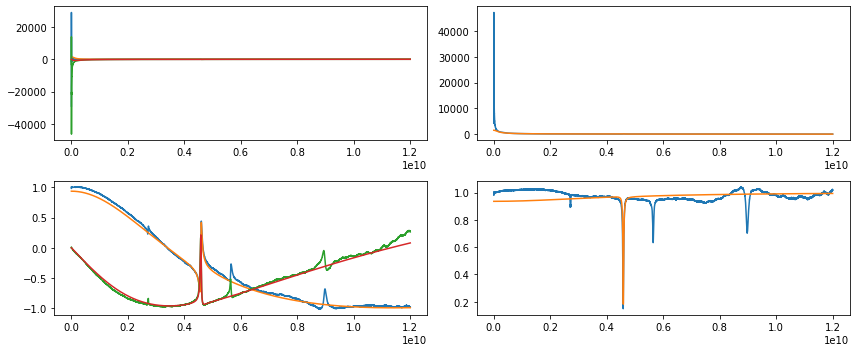

In [18]:
print(Fit_params_4K)
#Fit_params_4K = [0.1e-1, 6, 0.6e2, 1.5e-3]

# Generate some example frequency
Y3 = modified_BVD_model(freq, Lm=149, Cm=0.813, Rm=16) # Signal at 4.8 GHz

# Calculate Z0
jOmega = 1j*2*np.pi*freq
L0, Rs, R0, C0 = Fit_params_4K[0]*1e-9, Fit_params_4K[1], Fit_params_4K[2], (Fit_params_4K[3])*1e-9 
Z0 = np.array(1/(1/R0 + jOmega*C0)) 

# Calculate the N combined admittances
Y_N =  Y3

# Calculate the total impedance
Z_total = jOmega*L0 + Rs + 1/(1/Z0 + Y_N)  

# Calculate the total impedance
Y_total = 1/Z_total 

# Calculate the S11 from total impedance
s11_fit = convert_imped_to_s11(Z_total)

# Plot the fitted admittance and the S11
plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

#Save the variables for supporting figures
freq_sup = freq
Z_sup = Impedance_data
Z_fit_sup = Z_total
S11_data_sup = s11_pol
S11_fit_sup = s11_fit

Text(0.5, 0, 'Frequency(GHz)')

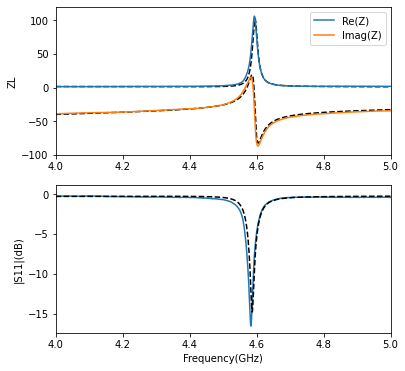

In [19]:
imped_fit = Z_total

fig = plt.figure(figsize=(6,6))
ax3 = plt.subplot(211)
ax4 = plt.subplot(212)

ax3.plot(freq/1e9, (imped_fit).real, "--", color = 'black')
ax3.plot(freq/1e9, Impedance_data.real, label = 'Re(Z)')
ax3.plot(freq/1e9, (imped_fit).imag, "--", color = 'black')
ax3.plot(freq/1e9, Impedance_data.imag, label = 'Imag(Z)')
ax3.set_xlim(4, 5)
ax3.set_ylim(-100,120)
ax3.set_ylabel('ZL')
ax3.legend()

ax4.plot(freq/1e9, 20*np.log10(abs(s11_pol)) )
ax4.plot(freq/1e9, 20*np.log10(abs(s11_fit)), "--", color = "black")
ax4.set_xlim(4, 5)
#ax4.set_ylim(-5,0)
ax4.set_ylabel('|S11|(dB)')
ax4.set_xlabel('Frequency(GHz)')


In [20]:
def calculate_power_ratio(fit_Z_total, fit_s11, Rs, fit_YN_list, Pwr_input = 1, cmpl_chrt_Imp = 50):
    # The following calculation assume the complex Characteristic Impedance (cmpl_chrt_Imp) is real = 50 ohm
    # See the effective circuit shown above for reference
    # Set in the arguments
    
    # V_Load and I_Load means the total voltage and current on the total load Z_total
    V_Load_RMS = np.sqrt(Pwr_input*cmpl_chrt_Imp/(1-fit_s11**2))*(1+fit_s11) # Load voltage
    I_Load_RMS = V_Load_RMS/fit_Z_total # Load current (total current flowing in)
    
    # Calculate the power ratio on Z0
    I_Z0_RMS = I_Load_RMS # Current through Z0
    V_Z0_RMS = I_Z0_RMS * Rs # Voltage across Z0
    Pwr_Z0 = V_Z0_RMS * I_Z0_RMS  # Power ratio of Z0
    
    
    # Calculate the power ration on YN
    Pwr_YN_list = []
    V_YN_RMS = V_Load_RMS - V_Z0_RMS # Voltage across admittance Y_N
    for fit_YN in fit_YN_list:
        I_YN = V_YN_RMS * fit_YN # fit_Y_N where N = 1, 2, 3 ,,,, N
        Pwr_YN = V_YN_RMS * np.conj(I_YN)  # Power ratio of YN
        Pwr_YN_list.append(Pwr_YN.real)
    
    return Pwr_YN_list

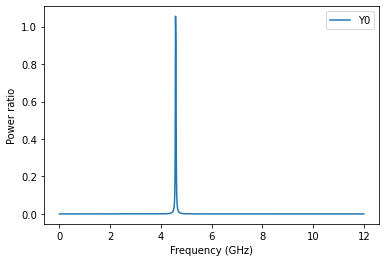

In [21]:
Pwr_YN_list = calculate_power_ratio(fit_Z_total = Z_total,
                                    fit_s11 = s11_fit,
                                    Rs = Rs,
                                    fit_YN_list = [Y3])

for i, Pwr_YN in enumerate(Pwr_YN_list):
    plt.plot(freq/1e9, abs(Pwr_YN), label= 'Y'+str(i))

plt.xlabel('Frequency (GHz)')
plt.ylabel('Power ratio')
plt.legend()

# Save variable for supporting figures
Pwr_YN_list_sup = Pwr_YN_list

# SOS - 4K delay line data 

In [40]:
def import_data( DL_dir_name, file_names):
    # Grab file name and store in DL list
    DL_S11 = glob(DL_dir_name + file_names[0])
    DL_S11.sort(key = sortKeyFunc_FD)
    DL_S22 = glob(DL_dir_name + file_names[1])
    DL_S22.sort(key = sortKeyFunc_FD)
    DL_S12 = glob(DL_dir_name + file_names[2])
    DL_S12.sort(key = sortKeyFunc_FD)
    DL_S21 = glob(DL_dir_name + file_names[3])
    DL_S21.sort(key = sortKeyFunc_FD)

    # Import frequency domain data
    S11_list = []
    S22_list = []
    S12_list = []
    S21_list = []

    for fn_11, fn_12, fn_21, fn_22 in zip(DL_S11, DL_S12, DL_S21, DL_S22):
        freq11, r11, i11 = import_pol_data(fn_11, print_file_name=False)
        freq12, r12, i12 = import_pol_data(fn_12)
        freq21, r21, i21 = import_pol_data(fn_21)
        freq22, r22, i22 = import_pol_data(fn_22)
        
        S11_list.append(r11 + 1j*i11)
        S12_list.append(r12 + 1j*i12)
        S21_list.append(r21 + 1j*i21)
        S22_list.append(r22 + 1j*i22)

    return freq11, freq21, S11_list, S12_list, S21_list, S22_list

In [41]:
root_path = r'/Users/itungchen/UW_lab_data/'
DL_dir_name =  root_path + '/20230530-GREASE-4K//' 
file_name = ['4K-*-S11-pol.prn', '4K-*-S22-pol.prn', '4K-*-S12-pol.prn', '4K-*-S21-pol.prn']

def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[3:-12])

freq11, freq21, S11_list_4K, S12_list_4K, S21_list_4K, S22_list_4K = import_data(file_names=file_name , DL_dir_name=DL_dir_name)


In [42]:
ifft_list_4K = []
for cmpl_s21 in S21_list_4K:
    N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq21, print_time_reso = False)
    ifft_list_4K.append(s21_ift)

time_gated_FD_list_4K = []
for ifft_data in ifft_list_4K:
    _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq21, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = True,
                                                                                    filter_peaks = False,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = True,
                                                                                    t_noise=[10], expand_noise = 0.1,
                                                                                    t_peaks=[0], expand_peaks = 200,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 1300,
                                                                                    xmax=1000, ymax=1000e-6, ymax_fdom = 10e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = False)

    time_gated_FD_list_4K.append(nor_cmpl_filtered)


Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...


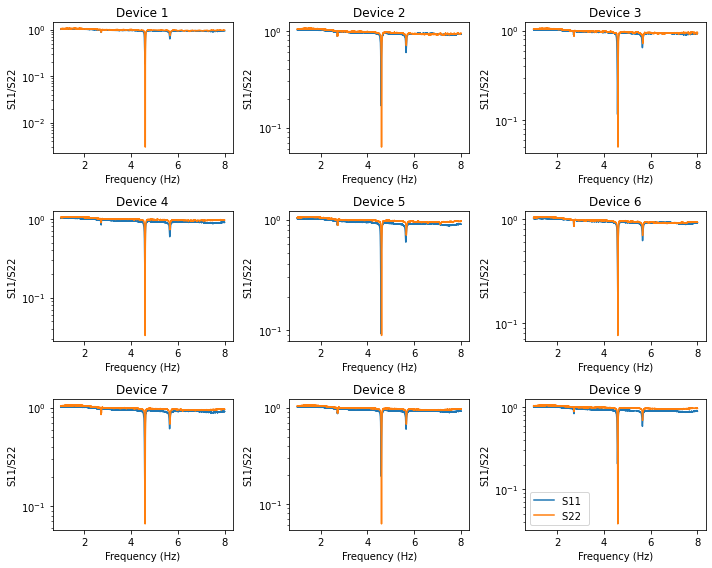

In [45]:
# Try to correct the IDT efficiency. Assuming the IDT efficiency is similar for all devices except deivce 6,7,8
# Plot a figure with 4 by 3 subplots
fig, ax = plt.subplots(3,3, figsize=(10, 8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(freq11/1e9, np.abs(S11_list_4K[i*3+j]), label = 'S11 ' )
        ax[i,j].plot(freq11/1e9, np.abs(S22_list_4K[i*3+j]), label = 'S22 ' )
        ax[i,j].set_xlabel('Frequency (Hz)')
        ax[i,j].set_ylabel('S11/S22')
        ax[i,j].title.set_text('Device '+str(i*3+j+1))
        ax[i,j].set_yscale('log')
        #ax[i,j].set_xlim(7e9, 8e9)
        #ax[i,j].set_ylim(0, 0.00055)
ax[i,j].legend()

plt.tight_layout()

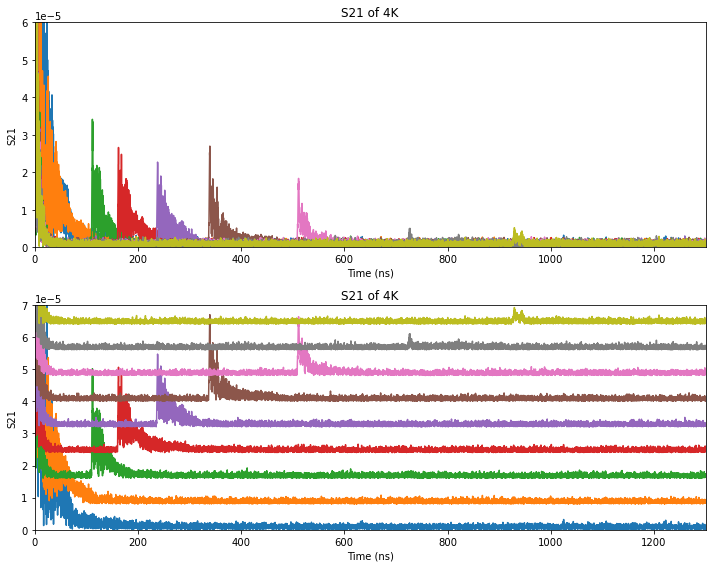

In [44]:
# Plot two plots: one is the time domain with a larger time span, the other is the time domain with a smaller time span and smaller y limit
fig, ax = plt.subplots(2,1, figsize=(10, 8))
for i in range(len(ifft_list_4K)):
    ax[0].plot(t_span/1e-9, np.abs(ifft_list_4K[i]), label = 'S21 ' + str(i))
    ax[1].plot(t_span/1e-9, np.abs(ifft_list_4K[i]) + 0.8e-5*i, label = 'S21 ' + str(i))

ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('S21')
ax[0].set_title('S21 of 4K')
ax[0].set_xlim(0, 1300)
ax[0].set_ylim(0, 6e-5)
#ax[0].legend()

ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('S21')
ax[1].set_title('S21 of 4K')
#ax[1].legend()
ax[1].set_xlim(0, 1300)
ax[1].set_ylim(0, 7e-5)

plt.tight_layout()

[0.004282637652242083, 0.0041641219081003595, 0.0022125807340154704, 0.001962513092989449, 0.001989477819594221, 0.0016961821211532815, 0.0013123436691587964, 0.000464695542588712, 0.0005651095275588553]


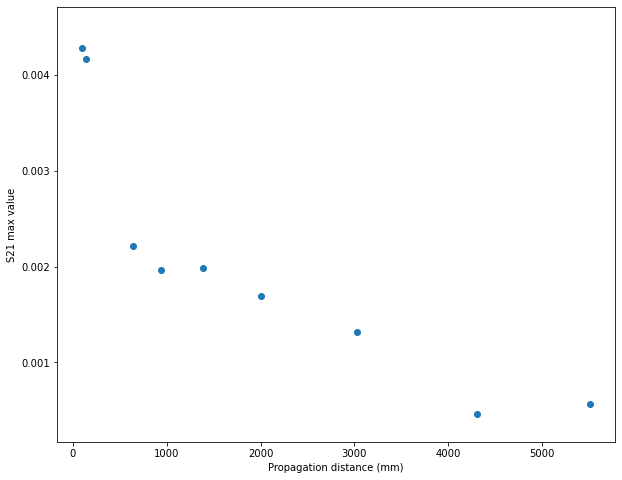

In [46]:
# Search for the index between 7GHz and 8GHz
start = 4e9 #Hz
end = 5e9 #Hz

# Find the indices of the range in xdata
start_idx = np.argmin(np.abs(freq21 - start))
end_idx = np.argmin(np.abs(freq21 - end))

# Find the maximum value between the two indices
S21_max_list_4K = []
for time_gated_data in time_gated_FD_list_4K:
    Max_value = np.max(np.abs(time_gated_data[start_idx:end_idx]))
    S21_max_list_4K.append(Max_value)

# Plot the S21 max values
prop_distance =  [102, 141 ,643, 935, 1385, 2000, 3025, 4305, 5505]

fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list_4K, 'o')
ax.set_xlabel('Propagation distance (mm)')
ax.set_ylabel('S21 max value')

# Set y limit
ax.set_ylim(S21_max_list_4K[-1]*0.3, S21_max_list_4K[0]*1.1)

print(S21_max_list_4K)

[0.00347946 1.03957165]


Text(0.25, 0.9, '$|\\alpha| = $0.169 dB/mm')

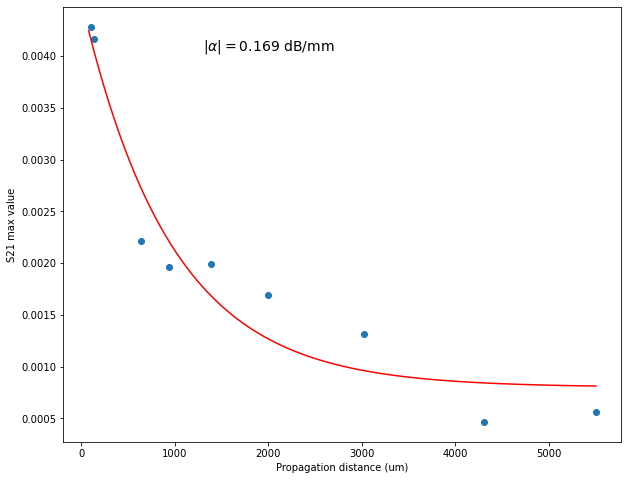

In [72]:
# Fit the data with a exponential decay function with decay constant
def exp_decay(x, b, alpha):
    return b*np.exp(-alpha*(x-70e-3)) + 0.0008

popt, pcov = curve_fit(exp_decay, np.array(prop_distance)*1e-3, np.array(S21_max_list_4K), p0=[1, 0.1])

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, np.array(S21_max_list_4K), 'o')
x_fit = np.linspace(80, prop_distance[-1], 100)
print(popt)
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *popt), 'r-')
ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$|\alpha| = $' + str(abs(np.round(10*np.log10(popt[1]), 3))) + ' dB/mm', transform=ax.transAxes, fontsize=14)


# SOS - RT delay line data

In [73]:
root_path = r'/Users/itungchen/UW_lab_data/'
DL_dir_name =  root_path + '/20230424-SOS-DL//' 
file_name = ['RT-*-S11-pol.prn', 'RT-*-S22-pol.prn', 'RT-*-S12-pol.prn', 'RT-*-S21-pol.prn']

def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[3:-12])

freq11, freq21, S11_list_RT, S12_list_RT, S21_list_RT, S22_list_RT = import_data(file_names=file_name , DL_dir_name=DL_dir_name)


In [75]:
ifft_list_RT = []
for cmpl_s21 in S21_list_RT:
    N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq21, print_time_reso = False)
    ifft_list_RT.append(s21_ift)

time_gated_FD_list_RT = []
for ifft_data in ifft_list_RT:
    _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq21, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = True,
                                                                                    filter_peaks = False,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = True,
                                                                                    t_noise=[10], expand_noise = 0.1,
                                                                                    t_peaks=[0], expand_peaks = 200,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 1300,
                                                                                    xmax=1000, ymax=1000e-6, ymax_fdom = 10e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = False)

    time_gated_FD_list_RT.append(nor_cmpl_filtered)


Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...


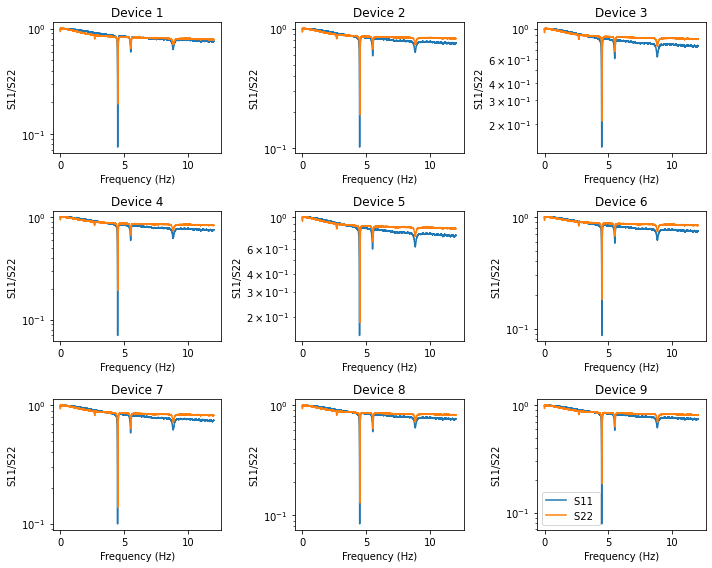

In [77]:
# Try to correct the IDT efficiency. Assuming the IDT efficiency is similar for all devices except deivce 6,7,8
# Plot a figure with 4 by 3 subplots
fig, ax = plt.subplots(3,3, figsize=(10, 8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(freq11/1e9, np.abs(S11_list_RT[i*3+j]), label = 'S11 ' )
        ax[i,j].plot(freq11/1e9, np.abs(S22_list_RT[i*3+j]), label = 'S22 ' )
        ax[i,j].set_xlabel('Frequency (Hz)')
        ax[i,j].set_ylabel('S11/S22')
        ax[i,j].title.set_text('Device '+str(i*3+j+1))
        ax[i,j].set_yscale('log')
        #ax[i,j].set_xlim(7e9, 8e9)
        #ax[i,j].set_ylim(0, 0.00055)
ax[i,j].legend()

plt.tight_layout()

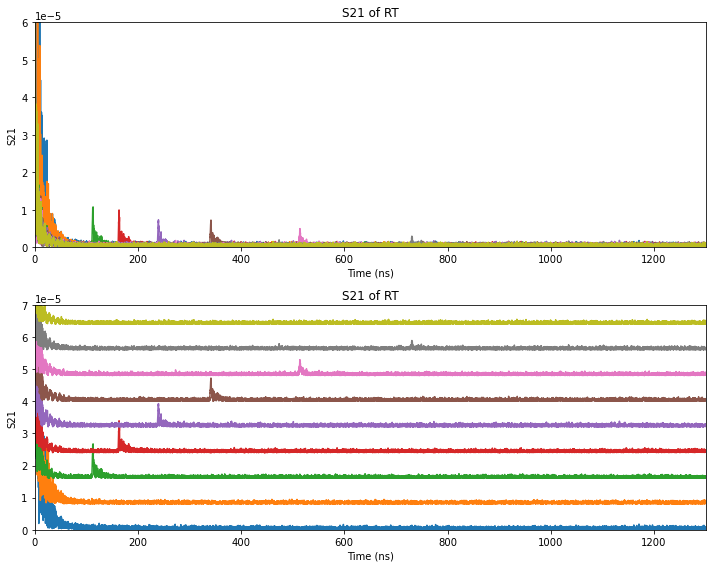

In [80]:
# Plot two plots: one is the time domain with a larger time span, the other is the time domain with a smaller time span and smaller y limit
fig, ax = plt.subplots(2,1, figsize=(10, 8))
for i in range(len(ifft_list_4K)):
    ax[0].plot(t_span/1e-9, np.abs(ifft_list_RT[i]), label = 'S21 ' + str(i))
    ax[1].plot(t_span/1e-9, np.abs(ifft_list_RT[i]) + 0.8e-5*i, label = 'S21 ' + str(i))

ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('S21')
ax[0].set_title('S21 of RT')
ax[0].set_xlim(0, 1300)
ax[0].set_ylim(0, 6e-5)
#ax[0].legend()

ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('S21')
ax[1].set_title('S21 of RT')
#ax[1].legend()
ax[1].set_xlim(0, 1300)
ax[1].set_ylim(0, 7e-5)

plt.tight_layout()

[0.0020313814122784376, 0.0012951391004870597, 0.0004904001945599694, 0.0005554108634272593, 0.00039994357201238666, 0.0005097158788467385, 0.00033851078278772964, 0.00025633370132350516, 0.0001637865055063799]


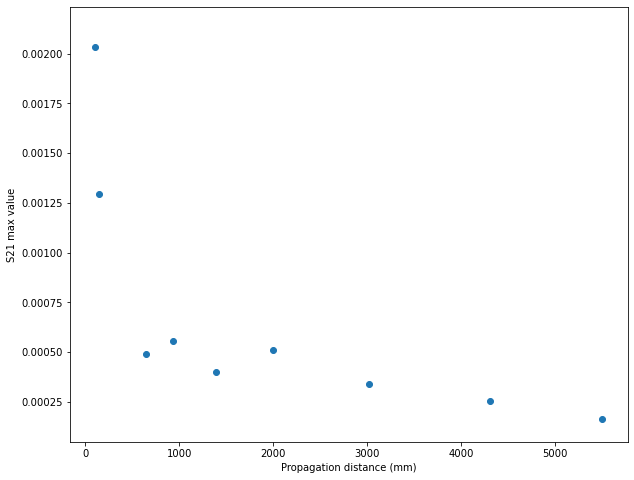

In [82]:
# Search for the index between 7GHz and 8GHz
start = 4e9 #Hz
end = 5e9 #Hz

# Find the indices of the range in xdata
start_idx = np.argmin(np.abs(freq21 - start))
end_idx = np.argmin(np.abs(freq21 - end))

# Find the maximum value between the two indices
S21_max_list_RT = []
for time_gated_data in time_gated_FD_list_RT:
    Max_value = np.max(np.abs(time_gated_data[start_idx:end_idx]))
    S21_max_list_RT.append(Max_value)

# Plot the S21 max values
prop_distance =  [102, 141 ,643, 935, 1385, 2000, 3025, 4305, 5505]

fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list_RT, 'o')
ax.set_xlabel('Propagation distance (mm)')
ax.set_ylabel('S21 max value')

# Set y limit
ax.set_ylim(S21_max_list_RT[-1]*0.3, S21_max_list_RT[0]*1.1)

print(S21_max_list_RT)

[1.66415705e-03 2.49022902e+00]


Text(0.25, 0.9, '$|\\alpha| = $3.962 dB/mm')

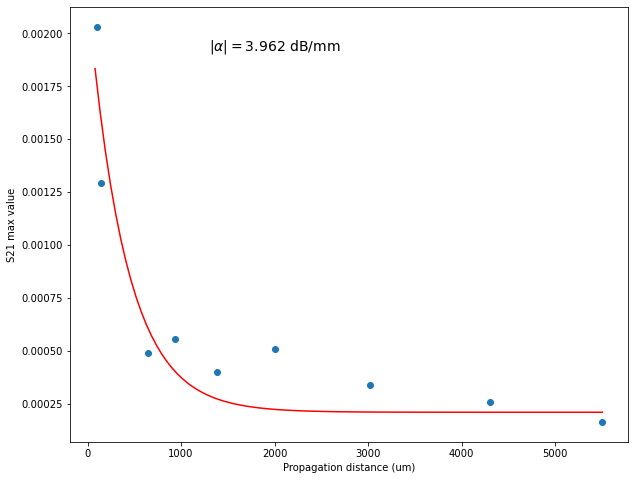

In [98]:
# Fit the data with a exponential decay function with decay constant
def exp_decay(x, b, alpha):
    return b*np.exp(-alpha*(x-70e-3)) + 0.00021

popt, pcov = curve_fit(exp_decay, np.array(prop_distance)*1e-3, np.array(S21_max_list_RT), p0=[1, 0.1])

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, np.array(S21_max_list_RT), 'o')
x_fit = np.linspace(80, prop_distance[-1], 100)
print(popt)
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *popt), 'r-')
ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$|\alpha| = $' + str(abs(np.round(10*np.log10(popt[1]), 3))) + ' dB/mm', transform=ax.transAxes, fontsize=14)

In [102]:

def process_acoustic_data(path_to_file, file_name):
    
        # Inport the data
        freq11, freq21, S11_list, S12_list, S21_list, S22_list = import_data(file_names= file_name , DL_dir_name= path_to_file)
        
        

        
        # Perform IFFT
        ifft_list = []
        for cmpl_s21 in S21_list:
                N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq21, print_time_reso = False)
                ifft_list.append(s21_ift)

        # Perform time gating
        time_gated_FD_list = []
        for ifft_data in ifft_list:
                _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq21, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = True,
                                                                                    filter_peaks = False,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = True,
                                                                                    t_noise=[10], expand_noise = 0.1,
                                                                                    t_peaks=[0], expand_peaks = 200,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 1300,
                                                                                    xmax=1000, ymax=1000e-6, ymax_fdom = 10e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = False)

                time_gated_FD_list.append(nor_cmpl_filtered)
        
        # Search for the index between 7GHz and 8GHz
        start = 4e9 #Hz
        end = 5e9 #Hz

        # Find the indices of the range in xdata
        start_idx = np.argmin(np.abs(freq21 - start))
        end_idx = np.argmin(np.abs(freq21 - end))

        # Find the maximum value between the two indices
        S21_max_list = []
        for time_gated_data in time_gated_FD_list:
                Max_value = np.max(np.abs(time_gated_data[start_idx:end_idx]))
                S21_max_list.append(Max_value)

        # Plot the S21 max values
        prop_distance =  [102, 141 ,643, 935, 1385, 2000, 3025, 4305, 5505]

        fig, ax = plt.subplots(1,1, figsize=(10, 8))
        ax.plot(prop_distance, S21_max_list, 'o')
        ax.set_xlabel('Propagation distance (mm)')
        ax.set_ylabel('S21 max value')

        # Set y limit
        ax.set_ylim(S21_max_list[-1]*0.3, S21_max_list[0]*1.1)

        print(S21_max_list)
                
        return freq11, S11_list, S22_list, ifft_list, time_gated_FD_list, S21_max_list
        
        

# SOS - 10K delay line data

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.00451731452809631, 0.004044714692533486, 0.002325774067535988, 0.0020303105770627505, 0.0017591959520905022, 0.0016196144464898884, 0.0014700358363074666, 0.0004949811377931669, 0.0004039026904476979]


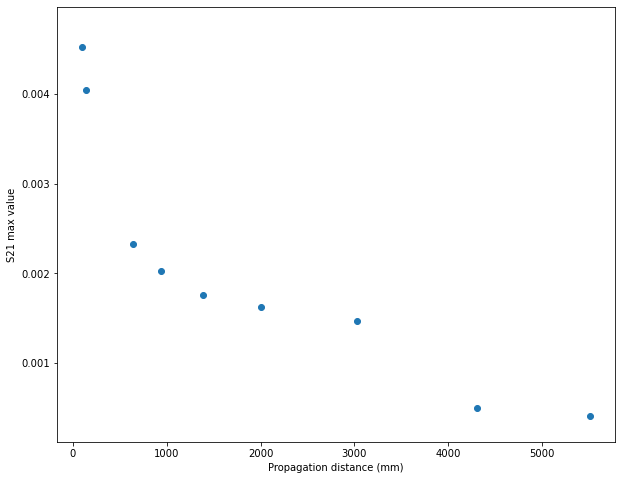

In [105]:
def sortKeyFunc_FD(s):
        return int(os.path.basename(s)[4:-12])
root_path = r'/Users/itungchen/UW_lab_data/'
path_to_file =  root_path + '/20230530-GREASE-4K//' 
file_name = ['10K-*-S11-pol.prn', '10K-*-S22-pol.prn', '10K-*-S12-pol.prn', '10K-*-S21-pol.prn']

freq11, S11_list, S22_list, ifft_list, time_gated_FD_list, S21_max_list_10K = process_acoustic_data(path_to_file, file_name)

[0.00358812 1.09914751]


Text(0.25, 0.9, '$|\\alpha| = $0.411 dB/mm')

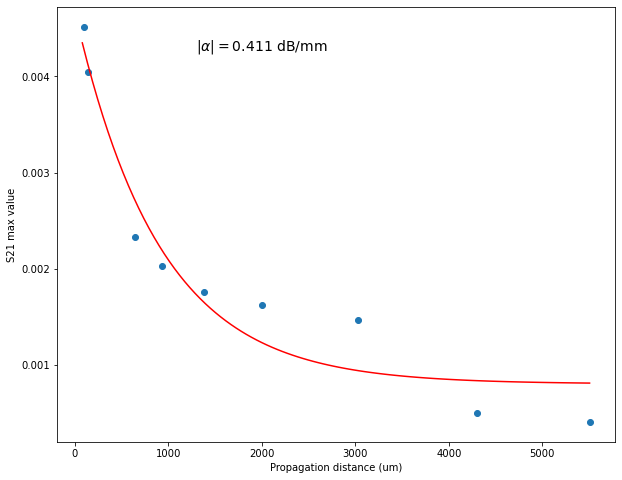

In [114]:
# Fit the data with a exponential decay function with decay constant
def exp_decay(x, b, alpha):
    return b*np.exp(-alpha*(x-70e-3)) + 0.0008

popt, pcov = curve_fit(exp_decay, np.array(prop_distance)*1e-3, np.array(S21_max_list_10K), p0=[1, 0.1])

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, np.array(S21_max_list_10K), 'o')
x_fit = np.linspace(80, prop_distance[-1], 100)
print(popt)
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *popt), 'r-')
ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$|\alpha| = $' + str(abs(np.round(10*np.log10(popt[1]), 3))) + ' dB/mm', transform=ax.transAxes, fontsize=14)

# SOS - 20K delay line data

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.004483638355452306, 0.004062905258365602, 0.002474694184020971, 0.0020683161896120055, 0.0019208989713899525, 0.0016165914460672622, 0.0015742355496259804, 0.00045999713324222327, 0.0004945159856432578]


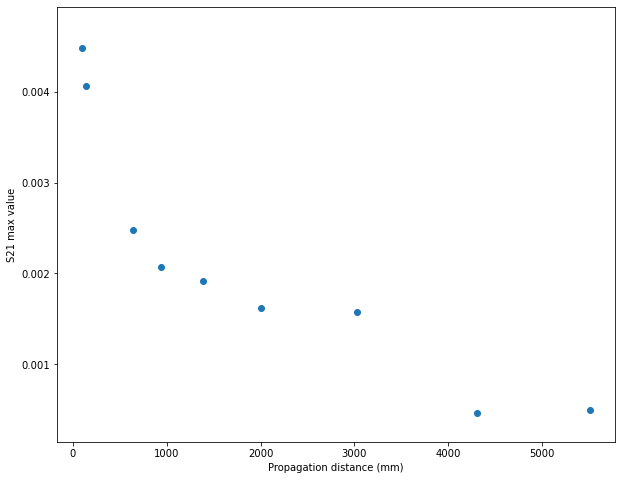

In [119]:
def sortKeyFunc_FD(s):
        return int(os.path.basename(s)[4:-12])
root_path = r'/Users/itungchen/UW_lab_data/'
path_to_file =  root_path + '/20230530-GREASE-4K//' 
file_name = ['20K-*-S11-pol.prn', '20K-*-S22-pol.prn', '20K-*-S12-pol.prn', '20K-*-S21-pol.prn']

freq11, S11_list, S22_list, ifft_list, time_gated_FD_list, S21_max_list_20K = process_acoustic_data(path_to_file, file_name)

[0.00368413 0.83307349]


Text(0.25, 0.9, '$|\\alpha| = $0.793 dB/mm')

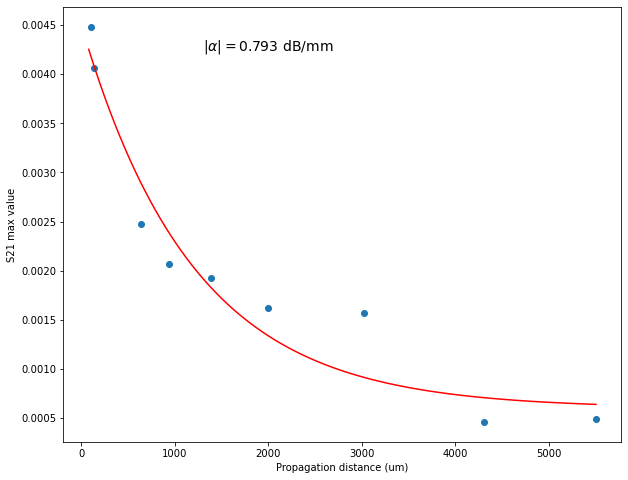

In [120]:
# Fit the data with a exponential decay function with decay constant
def exp_decay(x, b, alpha):
    return b*np.exp(-alpha*(x-70e-3)) + 0.0006

popt, pcov = curve_fit(exp_decay, np.array(prop_distance)*1e-3, np.array(S21_max_list_20K), p0=[1, 0.1])

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, np.array(S21_max_list_20K), 'o')
x_fit = np.linspace(80, prop_distance[-1], 100)
print(popt)
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *popt), 'r-')
ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$|\alpha| = $' + str(abs(np.round(10*np.log10(popt[1]), 3))) + ' dB/mm', transform=ax.transAxes, fontsize=14)

# SOS - Temperature depedent loss

[0.02779526 0.70217998 0.96467203]


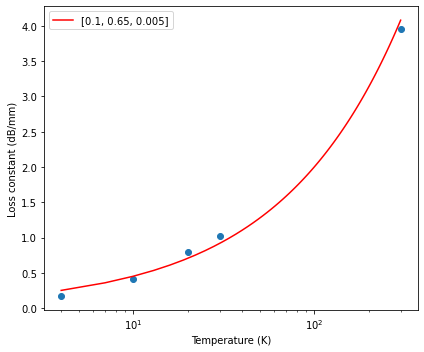

In [171]:
lost_list = np.array([0.169, 0.411, 0.793, 1.016, 3.962])  #dB/mm
#lost_err = np.array([0.6, 0.074, 0.4, 0.11, 0.62, 0.91, 0.86, 0.87, 0.21, 0.16, 0.29]) *0.8
T_list =    [4, 10, 20, 30, 300] # K

def temp_fit(x, a, b, c):
    return a*(x)**b + c 

popt, pcov = curve_fit(temp_fit, T_list, 10**(np.array(lost_list)/10), p0=[0.1, 0.5, 5e-3], bounds=([0, 0, 0], [np.inf, 2, 1]))


print(popt)
popt = [0.1, 0.65, 5e-3]
# Plot lost_list versus T_list
fig, ax = plt.subplots(1,1, figsize=(6, 5))
ax.plot(T_list, lost_list, 'o')
#ax.errorbar(T_list, lost_list, yerr=lost_err, fmt='o')
T_fit = np.linspace(4, 300, 100)
ax.plot(T_fit, temp_fit(np.array(T_fit), *popt), 'r-', label=str(popt))
ax.set_xscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Loss constant (dB/mm)')
ax.legend()
fig.tight_layout()

# SOS 1550nm Ring

In [172]:
# Define the import function
def import_GC_data(dir_name, file_name):
    
    #Print imported file name
    print('File name:', file_name)
    
    #Import file
    data = pd.read_csv(dir_name+file_name , header=None, sep= '\s+', skiprows =[0])
    
    #Get the data from the file
    wavelength =np.array(data[0])
    transmission =np.array(data[1])
    
    return wavelength, transmission

File name: device2-2.txt


(1552.0, 1552.27)

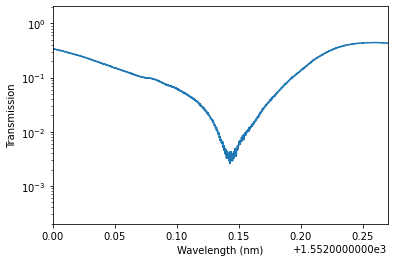

In [173]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#Specify the file name
dir_name_0626 = r'/Users/itungchen/UW_lab_data/20230515-SOS-1550Ring//'
file_name = 'device2-2.txt'

#import file
wl, t = import_GC_data(dir_name_0626, file_name)
plt.plot(wl, t)
plt.yscale('log')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmission')
plt.xlim(1552.0, 1552.27)

# BELOW OLD NOTEBOOK

In [21]:
# Make a function that let me mannually fit the idt efficiency with parameters
def manual_efficiency(s11_pol, freq, Lm=50, Cm=0.895, Rm=25, plot = False, auto_fit = False, p0=25, bounds = (1, 100), ftol = 1e-5):
    
    # Actual fitting functions below
    Impedance_data = convert_s11_to_impedance(s11_pol)

    # Fit background
    # Define the fitting range
    start_bg, end_bg = 1e9, 5e9 #Hz
    start_bg2, end_bg2 = 8e9, 12e9

    # Define the initial fitting params
    p0_bg = [0.2, 1e-6, 500, 1e-2]
    _, _, Fit_params_4K = fit_BVD_model_background_4K(freq, Impedance_data, start_bg, end_bg, start_bg2, end_bg2, p0_bg, bounds_bg, ftol, max_nfev)
    
    # The part where the manual fitting starts----------------------------------
    if auto_fit == False:
        
        # Calculate Z0
        jOmega = 1j*2*np.pi*freq
        L0, Rs, R0, C0 = Fit_params_4K[0]*1e-9, Fit_params_4K[1], Fit_params_4K[2], (Fit_params_4K[3])*1e-9 
        Z0 = np.array(1/(1/R0 + jOmega*C0)) 

        # Generate some example frequency
        Y3 = modified_BVD_model(freq, Lm=Lm, Cm=Cm, Rm=Rm) # Signal at 7.5 GHz

        # Calculate the N combined admittances
        Y_N =  Y3

        # Calculate the total impedance
        Z_total = jOmega*L0 + Rs + 1/(1/Z0 + Y_N)  

        # Calculate the total impedance
        Y_total = 1/Z_total 

        # Calculate the S11 from total impedance
        s11_fit = convert_imped_to_s11(Z_total)

    if auto_fit == True:
        start, end = 7e9, 8e9

        # Find the indices of the range in xdata
        start_idx1 = np.argmin(np.abs(freq - start))
        end_idx1 = np.argmin(np.abs(freq - end))

        # Slice xdata and ydata to the two specified ranges and concatenate them
        Freq_fit = freq[start_idx1:end_idx1+1]
        Admittance_fit = 1/Impedance_data[start_idx1:end_idx1+1]

        L0, Rs, R0, C0 = Fit_params_4K[0]*1e-9, Fit_params_4K[1], Fit_params_4K[2], (Fit_params_4K[3])*1e-9 
        
        try:
            # Perform fitting
            popt, _  = curve_fit(lambda f, R_fit:
                                hstack_BVD_for_fit(1/( 1j*2*np.pi*f*L0 + Rs + 1/(1/np.array(1/(1/R0 + 1j*2*np.pi*f*C0)) + modified_BVD_model(f, Lm=Lm, Cm=Cm, Rm=R_fit)))),
                                Freq_fit,
                                np.hstack((Admittance_fit.real, Admittance_fit.imag)),
                                p0= p0,
                                bounds = bounds,
                                ftol = ftol)
            Rm_fit = popt[0]
            
            Y3 = modified_BVD_model(freq, Lm=Lm, Cm=Cm, Rm=Rm_fit) # Signal at 7.5 GHz
            
            jOmega = 1j*2*np.pi*freq
            Z0 = np.array(1/(1/R0 + jOmega*C0))

            # Calculate the total impedance
            Z_total = jOmega*L0 + Rs + 1/(1/Z0 + Y3)

            # Calculate the S11 from total impedance
            s11_fit = convert_imped_to_s11(Z_total)
            print(popt)
        except:
            print('Fitting failed')
            return 0
    # The part where the manual fitting ends----------------------------------

    # Calculate the power ratio
    Pwr_YN_list = calculate_power_ratio(fit_Z_total = Z_total,
                                        fit_s11 = s11_fit,
                                        Rs = Rs,
                                        fit_YN_list = [Y3])
    
    if plot == True:
        
        # Plot the fitted admittance and the S11
        plot_fit(freq, Impedance_data, Z_total, s11_pol, s11_fit)

        fig = plt.figure()
        ax1 = plt.subplot(111)
        for i, Pwr_YN in enumerate(Pwr_YN_list):
            ax1.plot(freq/1e9, abs(Pwr_YN), label= 'Y'+str(i))

        ax1.set_xlabel('Frequency (GHz)')
        ax1.set_ylabel('Power ratio')
        ax1.legend()
    
    return np.max(abs(Pwr_YN_list[0]))


# Only Look at device 6, 7, 8.
List is [5,6,7]

In [22]:
IDT_efficiency_product =[]
p_ratio11 = manual_efficiency(s11_pol= S11_list_4K[0], freq = freq11, Lm=50, Cm=0.895, Rm=20, plot = False)
p_ratio22 = manual_efficiency(s11_pol= S22_list_4K[0], freq = freq11, Lm=50, Cm=0.895, Rm=6, plot = False)
IDT_efficiency_product.append(p_ratio11*p_ratio22)

p_ratio11 = manual_efficiency(s11_pol= S11_list_4K[1], freq = freq11, Lm=50, Cm=0.895, Rm=20, plot = False)
p_ratio22 = manual_efficiency(s11_pol= S22_list_4K[1], freq = freq11, Lm=50, Cm=0.895, Rm=6, plot = False)
print(p_ratio11)
print(p_ratio22)

p_ratio11 = manual_efficiency(s11_pol= S11_list_4K[2], freq = freq11, Lm=50, Cm=0.895, Rm=15, plot = False, auto_fit = False, p0 = [15])
p_ratio22 = manual_efficiency(s11_pol= S22_list_4K[2], freq = freq11, Lm=50, Cm=0.895, Rm=6, plot = False)
print(p_ratio11)
print(p_ratio22)

p_ratio11 = manual_efficiency(s11_pol= S11_list_4K[3], freq = freq11, Lm=50, Cm=0.895, Rm=20, plot = False, auto_fit = True, p0 = 10, bounds=(1,20), ftol=1e-5)
p_ratio22 = manual_efficiency(s11_pol= S22_list_4K[3], freq = freq11, Lm=50, Cm=0.895, Rm=6, plot = False, auto_fit = True, p0 = 10, bounds=(6,30), ftol=1e-7)

# This cell is device 6, 7, 8
p_ratio11 = manual_efficiency(s11_pol= S11_list_4K[5], freq = freq11, Lm=50, Cm=0.895, Rm=25, plot = False)
p_ratio22 = manual_efficiency(s11_pol= S22_list_4K[5], freq = freq11, Lm=50, Cm=0.895, Rm=15, plot = False)
print('Device 6')
print(p_ratio11)
print(p_ratio22)
p_ratio11 = manual_efficiency(s11_pol= S11_list_4K[6], freq = freq11, Lm=50, Cm=0.895, Rm=19, plot = False)
p_ratio22 = manual_efficiency(s11_pol= S22_list_4K[6], freq = freq11, Lm=50, Cm=0.895, Rm=15, plot = False)
print('Device 7')
print(p_ratio11)
print(p_ratio22)
p_ratio11 = manual_efficiency(s11_pol= S11_list_4K[7], freq = freq11, Lm=50, Cm=0.895, Rm=15, plot = False)
p_ratio22 = manual_efficiency(s11_pol= S22_list_4K[7], freq = freq11, Lm=50, Cm=0.895, Rm=6, plot = False)
print('Device 8')
print(p_ratio11)
print(p_ratio22)

L0 = 0.246431068195256 nH
Rs = 1.4119065035121076e-09 Ohm
R0 = 1499.9999602256646 Ohm
C0 = 0.0008408701773350194 nF
L0 = 0.12396906576936599 nH
Rs = 6.433743059716151e-10 Ohm
R0 = 1499.9999930793558 Ohm
C0 = 0.0016510065513447825 nF
L0 = 0.2565880859981744 nH
Rs = 5.047140277689015e-10 Ohm
R0 = 1499.9999599267296 Ohm
C0 = 0.0008299406328177658 nF
L0 = 0.12006388960659446 nH
Rs = 1.0000469456911624e-10 Ohm
R0 = 1499.9999952742469 Ohm
C0 = 0.001644106795395694 nF
1.066772665410061
1.9890687902943063
L0 = 0.25657066026026853 nH
Rs = 1.3359708590665093e-09 Ohm
R0 = 1499.9999625038697 Ohm
C0 = 0.0008311774587160175 nF
L0 = 0.12506512800865688 nH
Rs = 1.7731878510768302e-10 Ohm
R0 = 1499.9999959138515 Ohm
C0 = 0.0016433878607856765 nF
1.5023920092732104
1.9882499852044981
L0 = 0.264744798616995 nH
Rs = 5.788173202110311e-09 Ohm
R0 = 1499.999954713945 Ohm
C0 = 0.0008382636489487167 nF
[20.]
L0 = 0.11522614616965964 nH
Rs = 1.0000000000008613e-10 Ohm
R0 = 1499.9999999999998 Ohm
C0 = 0.00164581

In [23]:
idt_eff_list = []
for s11_pol, s22_pol in zip(S11_list_4K, S22_list_4K):
    p_ratio11 = manual_efficiency(s11_pol= s11_pol, freq = freq11, Lm=50, Cm=0.895, Rm=20, plot = False, auto_fit = True, p0 = 10, bounds=(1,20), ftol=1e-5)
    p_ratio22 = manual_efficiency(s11_pol= s22_pol, freq = freq11, Lm=50, Cm=0.895, Rm=6, plot = False, auto_fit = True, p0 = 10, bounds=(6,30), ftol=1e-7)  
    idt_eff_list.append(p_ratio11*p_ratio22)
print(idt_eff_list)

L0 = 0.246431068195256 nH
Rs = 1.4119065035121076e-09 Ohm
R0 = 1499.9999602256646 Ohm
C0 = 0.0008408701773350194 nF
[20.]
L0 = 0.12396906157314787 nH
Rs = 1.0000002489920636e-10 Ohm
R0 = 1499.9999999999998 Ohm
C0 = 0.0016510065770089749 nF
[30.]
L0 = 0.2565880859981744 nH
Rs = 5.047140277689015e-10 Ohm
R0 = 1499.9999599267296 Ohm
C0 = 0.0008299406328177658 nF
[20.]
L0 = 0.12006388499251515 nH
Rs = 1.0000000000017915e-10 Ohm
R0 = 1499.9999999999998 Ohm
C0 = 0.0016441068232888327 nF
[30.]
L0 = 0.25657066026026853 nH
Rs = 1.3359708590665093e-09 Ohm
R0 = 1499.9999625038697 Ohm
C0 = 0.0008311774587160175 nF
[20.]
L0 = 0.12506512448067525 nH
Rs = 1.0000000267599715e-10 Ohm
R0 = 1499.9999999999998 Ohm
C0 = 0.0016433878823805628 nF
[30.]
L0 = 0.264744798616995 nH
Rs = 5.788173202110311e-09 Ohm
R0 = 1499.999954713945 Ohm
C0 = 0.0008382636489487167 nF
[20.]
L0 = 0.11522614616965964 nH
Rs = 1.0000000000008613e-10 Ohm
R0 = 1499.9999999999998 Ohm
C0 = 0.0016458187357792434 nF
[30.]
L0 = 0.259240632

In [174]:
#  S21 Normalization to the IDT efficiency
norm_s21 = S21_max_list_4K/np.array(idt_eff_list)

NameError: name 'idt_eff_list' is not defined

NameError: name 'norm_s21' is not defined

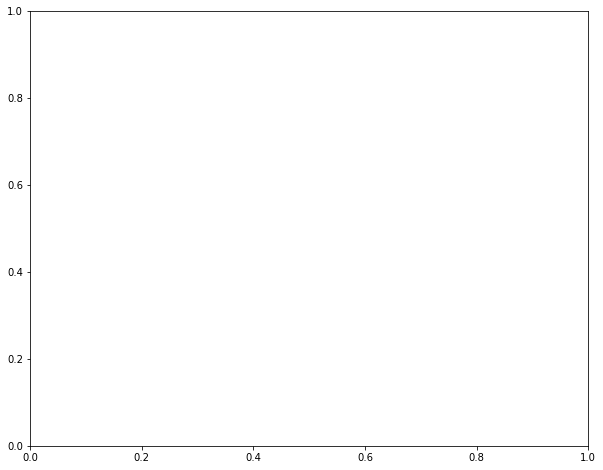

In [175]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, norm_s21, 'o')
ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Set y limit
ax.set_ylim(norm_s21[-1]*0.3, norm_s21[0]*1.1)

print(S21_max_list_4K)

Text(0.25, 0.9, '$\\alpha = $6.654 dB/mm')

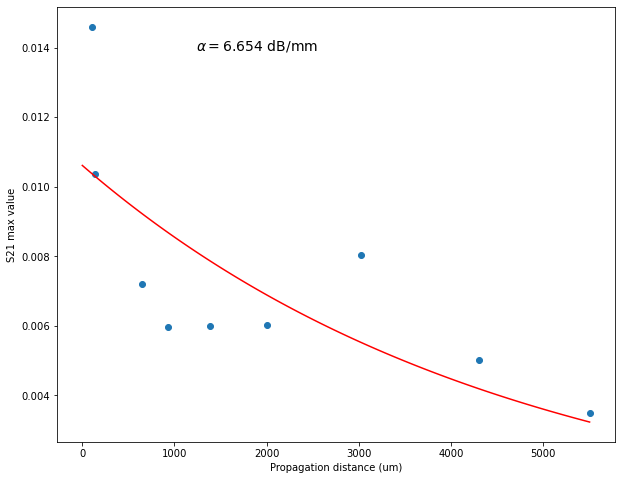

In [26]:
# Fit the data with a exponential decay function with decay constant
def exp_decay(x, b, alpha):
    return b*np.exp(-alpha*(x))

popt, pcov = curve_fit(exp_decay, np.array(prop_distance)*1e-3, norm_s21, p0=[0.06, 0.1])

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, norm_s21, 'o')
x_fit = np.linspace(0, prop_distance[-1], 100)

ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *popt), 'r-')
ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(-10*np.log10(popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)

# Do-it-all

In [27]:
# Define the sort function of the frequency domain data
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[4:-12])


def import_data( DL_dir_name, file_names):
    # Grab file name and store in DL list
    DL_S11 = glob(DL_dir_name + file_names[0])
    DL_S11.sort(key = sortKeyFunc_FD)
    DL_S22 = glob(DL_dir_name + file_names[1])
    DL_S22.sort(key = sortKeyFunc_FD)
    DL_S12 = glob(DL_dir_name + file_names[2])
    DL_S12.sort(key = sortKeyFunc_FD)
    DL_S21 = glob(DL_dir_name + file_names[3])
    DL_S21.sort(key = sortKeyFunc_FD)

    # Import frequency domain data
    S11_list = []
    S22_list = []
    S12_list = []
    S21_list = []

    for fn_11, fn_12, fn_21, fn_22 in zip(DL_S11, DL_S12, DL_S21, DL_S22):
        freq11, r11, i11 = import_pol_data(fn_11, print_file_name=False)
        freq12, r12, i12 = import_pol_data(fn_12)
        freq21, r21, i21 = import_pol_data(fn_21)
        freq22, r22, i22 = import_pol_data(fn_22)
        
        S11_list.append(r11 + 1j*i11)
        S12_list.append(r12 + 1j*i12)
        S21_list.append(r21 + 1j*i21)
        S22_list.append(r22 + 1j*i22)

    return freq11, freq21, S11_list, S12_list, S21_list, S22_list

In [35]:
# Define a function that does the fourier transform, extract the peak value of the S21 at the chosen frequency
# and correct the S21 value with the IDT efficiency and fit with the exponential decay function. Finally return the loss constant alpha
def get_alpha(freq11, freq21, S21_list, S11_list, S22_list,
            N_FIT = 11,
            manual_idt_eff = True, 
            plot_filter = False, 
            plot_num = 1, 
            manual_idt_list = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.2, 0.12, 0.2, 0.5 ]),
            max_val_expend = 5):
    # Fourier transform
    ifft_list = []
    for cmpl_s21 in S21_list:
        N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq21, print_time_reso = False)
        ifft_list.append(s21_ift)

    # Time gating
    time_gated_FD_list = []
    plot_filtering = False
    for num, ifft_data in enumerate(ifft_list):
        
        if num == plot_num and plot_filter == True:
            plot_filtering = True
        elif num != plot_num and plot_filter == True:
            plot_filtering = False

        _, nor_cmpl_filtered, t_span, filtered_ift_data, org_ift_data = Filter_S21_signals(   freq21, 
                                                                                        ifft_data, 
                                                                                        t_reso,   
                                                                                        N_pts = N_pts,  
                                                                                        filter_noise = True,
                                                                                        filter_peaks = False,
                                                                                        filter_picking = False, 
                                                                                        filter_stop = True,
                                                                                        t_noise=[1], expand_noise = 0.1,
                                                                                        t_peaks=[0], expand_peaks = 200,
                                                                                        t_picked = [0], expand_picked = 20,
                                                                                        t_stop = 1300,
                                                                                        xmax=1000, ymax=1000e-6, ymax_fdom = 10e-5, manual_scale= False,
                                                                                        savefig = False,
                                                                                        plot_filtering = plot_filtering)

        time_gated_FD_list.append(nor_cmpl_filtered)
        


    # Find the indices of the range in xdata
    start, end = 7e9, 8e9
    start_idx = np.argmin(np.abs(freq21 - start))
    end_idx = np.argmin(np.abs(freq21 - end))

    # Find the maximum value between the two indices
    S21_max_list = []
    S21_avg_list = []
    S21_errorbar_list = []
    for time_gated_data in time_gated_FD_list:
        Max_value = np.max(np.abs(time_gated_data[start_idx:end_idx]))
        S21_max_list.append(Max_value)

        # Find the index of the maximum value and expend around the max indx by N points and find the average and the minimum value
        Max_idx = np.argmax(np.abs(time_gated_data[start_idx:end_idx]))
        Max_idx = Max_idx + start_idx
        Min_value = np.min(np.abs(time_gated_data[Max_idx-max_val_expend:Max_idx+max_val_expend]))
        avg_value = np.average(np.abs(time_gated_data[Max_idx-max_val_expend:Max_idx+max_val_expend]))
        S21_avg_list.append(avg_value)
        
        
        print(np.abs(time_gated_data[Max_idx-max_val_expend:Max_idx+max_val_expend]))
        
    
    # Calculate IDT efficiency
    idt_eff_list = []
    for s11_pol, s22_pol in zip( S11_list, S22_list):
        p_ratio11 = manual_efficiency(s11_pol= s11_pol, freq = freq11, Lm=50, Cm=0.895, Rm=20, plot = False, auto_fit = True, p0 = 10, bounds=(1,20), ftol=1e-5)
        p_ratio22 = manual_efficiency(s11_pol= s22_pol, freq = freq11, Lm=50, Cm=0.895, Rm=6, plot = False, auto_fit = True, p0 = 10, bounds=(6,30), ftol=1e-7)  
        idt_eff_list.append(p_ratio11*p_ratio22)
    print(idt_eff_list)

    #  S21 Normalization to the IDT efficiency
    if manual_idt_eff == True:
        IDT_Manual_eff = manual_idt_list
        norm_s21 = S21_max_list/np.array(IDT_Manual_eff)
        norm_s21_avg = np.array(S21_avg_list)/np.array(IDT_Manual_eff)
        norm_s21_error = norm_s21**2 - norm_s21_avg**2

    else:
        norm_s21 = S21_max_list/np.array(idt_eff_list)
        norm_s21_avg = np.array(S21_avg_list)/np.array(idt_eff_list)
        norm_s21_error = norm_s21**2 - norm_s21_avg**2

    # Fit the data with a exponential decay function with decay constant
    exp_popt, pcov = curve_fit(exp_decay, np.array(prop_distance[:N_FIT])*1e-3, np.array(norm_s21[:N_FIT]), p0=[0.06, 0.1]) #Unit in mm
    exp_popt_min, pcov = curve_fit(exp_decay, np.array(prop_distance[:N_FIT])*1e-3, np.array(norm_s21_avg[:N_FIT]), p0=[0.06, 0.1]) #Unit in mm
    exp_popt_error = abs(abs(10*np.log10(exp_popt[1])) - abs(10*np.log10(np.abs(exp_popt_min[1]))))

    """
    Output:
    S21_max_list: list of maximum S21 value at the targeted frequency
    S21_avg_list: list of average S21 value at the targeted frequency
    S21_errorbar_list: list of errorbar of S21 value at the targeted frequency (the difference between the maximum and the minimum s21)
    norm_s21: list of normalized S21 value at the targeted frequency (normalized by the IDT efficiency)
    idt_eff_list: list of IDT efficiency
    exp_popt: list of fitted exponential decay constant and the offset
    exp_popt_error: error of the fitted exponential decay constant (alpha_fit_max - alpha_fit_min)
    """

    return  S21_max_list, S21_avg_list, norm_s21_error, norm_s21,  np.array(idt_eff_list), exp_popt, exp_popt_error
    

In [29]:
# Initialize a list to append all the S21 max list values
S21_max_export = []

# 4K

In [31]:
root_path = r'/Users/itungchen/UW_lab_data/'
DL_dir_name =  root_path + '/20230424-SOS-DL/4k-NOSILVERPASTE//' 
file_name = ['4K-*-S11-pol.prn', '4K-*-S22-pol.prn', '4K-*-S12-pol.prn', '4K-*-S21-pol.prn']

def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[3:-12])

freq11, freq21, S11_list_4K, S12_list_4K, S21_list_4K, S22_list_4K = import_data(file_names=file_name , DL_dir_name=DL_dir_name)



In [36]:
S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list_4K, S11_list_4K, S22_list_4K, 
                                                                                            plot_filter = False, plot_num = 9, N_FIT = 9, max_val_expend=5)

'''# Get the data for the combined plot
norm_s21_4K = norm_s21
norm_s21_4K_errorbar = S21_errorbar_list
exp_popt_4K = exp_popt
S21_max_export.append(S21_max_list) '''

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.00036271 0.00035332 0.00032225 0.00031977 0.00036384 0.00040299
 0.0003319  0.00031105 0.00034851 0.00033975]
[0.0002569  0.00028705 0.00025927 0.00022655 0.00027964 0.00029072
 0.00024794 0.00024884 0.0002676  0.00026621]
[1.19591678e-04 9.89285590e-05 1.12400824e-04 9.82898147e-05
 9.69305147e-05 1.23371708e-04 8.18718851e-05 1.14669473e-04
 1.05075511e-04 9.50244356e-05]
[1.04271453e-04 6.93559287e-05 7.16745075e-05 9.33274825e-05
 8.30117650e-05 1.18433299e-04 9.97302470e-05 9.71174352e-05
 9.21330214e-05 8.25226111e-05]
[0.00020081 0.00015983 0.00012101 0.00017013 0.00020344 0.00024858
 0.00020167 0.00013925 0.00011306 0.00015617]
[1.56983257e-04 1.52446529e-04 9.53304179e-05 6.06780082e-05
 1.13165958e-04 1.91860565e-04 1.29122109e-04 4.14182119e-05
 8.95153338e-05 1.54469995e-04]
[

'# Get the data for the combined plot\nnorm_s21_4K = norm_s21\nnorm_s21_4K_errorbar = S21_errorbar_list\nexp_popt_4K = exp_popt\nS21_max_export.append(S21_max_list) '

3.8237563961697596
[0.0005928 0.0387219]


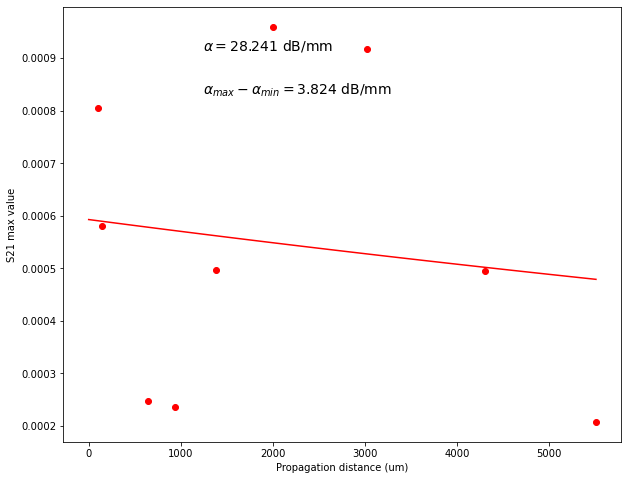

In [37]:
alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
# ax.plot(prop_distance, S21_max_list, 'o')
ax.errorbar(prop_distance, np.array(norm_s21), yerr=np.array(S21_errorbar_list), fmt='o', color='r')

# ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(-20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
ax.text(0.25, 0.8, r'$\alpha_{max} - \alpha_{min}= $' + str(np.round(exp_popt_error,3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)

print(exp_popt)

# 7K

In [220]:
root_path = r'/Users/itungchen/UW_lab_data/'
DL_dir_name =  root_path + '/20230406-bBGaP-Delay-lines//' 
file_name = ['7K-*-S11-pol.prn', '7K-*-S22-pol.prn', '7K-*-S12-pol.prn', '7K-*-S21-pol.prn']
manual_idt_eff = np.array([0.5, 0.47, 0.2, 0.5, 0.31, 0.2, 0.12, 0.4, 0.5, 0.5, 0.5, 0.5 ])
#manual_idt_eff = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ])
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[3:-12])

freq11, freq21, S11_list_7K, S12_list_7K, S21_list_7K, S22_list_7K = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list_7K, S11_list_7K, S22_list_7K, N_FIT = 11, manual_idt_eff=True, manual_idt_list = manual_idt_eff)

S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.02804559 0.02891609 0.02888871 0.02995678 0.03011394 0.03030435
 0.03013324 0.02967008 0.03013098 0.02999208]
[0.02801304 0.027949   0.02726613 0.02817821 0.02847488 0.02853774
 0.02834611 0.02774564 0.02837676 0.02732432]
[0.00706544 0.00667951 0.00569895 0.00629412 0.00603768 0.0075147
 0.0063145  0.00628344 0.00683978 0.0063458 ]
[0.02541923 0.02620615 0.02635006 0.02728529 0.02763032 0.02831021
 0.02809289 0.02742778 0.02727588 0.02537859]
[0.02263206 0.02349032 0.02442027 0.02421832 0.02459109 0.02479399
 0.02385241 0.02392426 0.02315313 0.02279976]
[0.00430011 0.00397671 0.00454016 0.00468733 0.00483022 0.00566324
 0.00389497 0.00312    0.00312392 0.00237425]
[0.0020753  0.00233545 0.0016144  0.00271473 0.00262093 0.0

[0.030304352663207967, 0.028537738799934605, 0.007514696829816749, 0.028310214346240915, 0.0247939902400456, 0.005663243492747779, 0.0030166898706789885, 0.007824611507905825, 0.006570803737185969, 0.0035159809559675037, 0.002411440761462103, 0.0019539221291174982]
[0.06027394 0.05975644 0.05647604 0.05867874 0.05974932 0.03080241
 0.02619464 0.01726321 0.01564983 0.00842006 0.00582294 0.00497203]
[0.06060871 0.06071859 0.03757348 0.05662043 0.07998061 0.02831622
 0.02513908 0.01956153 0.01314161 0.00703196 0.00482288 0.00390784]
0.22210067775875464
[0.06176724 0.850176  ]


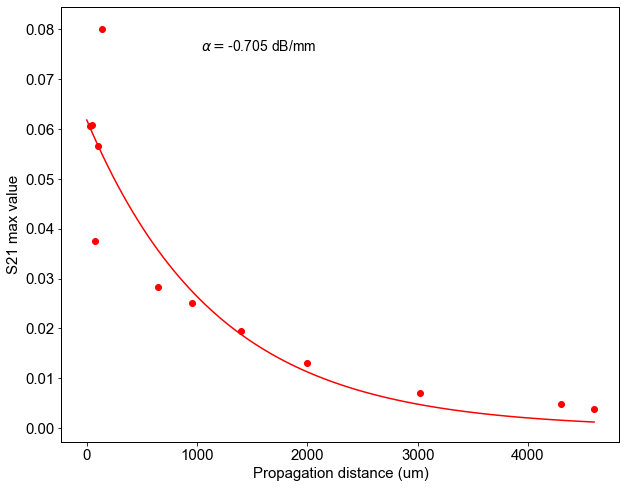

In [222]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
#ax.plot(prop_distance, S21_max_list, 'o')
#ax.errorbar(prop_distance, norm_s21, yerr=S21_errorbar_list, fmt='o', color='r')
#ax.plot(prop_distance, norm_s21, 'o')
ax.errorbar(prop_distance, np.array(norm_s21), yerr=np.array(S21_errorbar_list), fmt='o', color='r')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# 13K

In [223]:
file_name = ['13K-*-S11-pol.prn', '13K-*-S22-pol.prn', '13K-*-S12-pol.prn', '13K-*-S21-pol.prn']
manual_idt_eff = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.2, 0.12, 0.2, 0.5, 0.5, 0.5, 0.5 ])
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[4:-12])

freq11, freq21, S11_list_13K, S12_list_13K, S21_list_13K, S22_list_13K = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list_13K, S11_list_13K, S22_list_13K, N_FIT=11, manual_idt_eff=False, manual_idt_list = manual_idt_eff)
S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.02797688 0.02721336 0.02736496 0.02800633 0.02793163 0.02872884
 0.02803802 0.02811054 0.02856279 0.02810117]
[0.01803925 0.01757651 0.01744338 0.01799986 0.01797117 0.01839822
 0.01837626 0.01838012 0.0181867  0.0177181 ]
[0.02185277 0.02231794 0.02292668 0.02250183 0.02270075 0.0237827
 0.02313247 0.02266983 0.02282739 0.02267058]
[0.02427219 0.02409288 0.0248724  0.02490111 0.02485256 0.0252212
 0.02424742 0.02424309 0.02405283 0.02352996]
[0.02130941 0.022533   0.02396617 0.02424162 0.02516647 0.02556982
 0.02550455 0.02513066 0.02550962 0.02433129]
[0.00365414 0.00452135 0.00470875 0.0045643  0.00487405 0.0050376
 0.00427317 0.00415668 0.00344598 0.00372726]
[0.00119639 0.00121587 0.00172879 0.00174353 0.00206237 0.003

[0.028728844900523777, 0.018398224906680524, 0.023782698451206303, 0.025221195979867998, 0.025569821963349348, 0.005037595627562193, 0.0031053047336724367, 0.007473247104294317, 0.007307412196591042, 0.0034626266909364633, 0.002507992022714108, 0.0018016236220630094]
[0.06731546 0.04576206 0.05115226 0.05563648 0.06169404 0.02944773
 0.02394217 0.01694568 0.01734792 0.00826547 0.00600994 0.00449857]
[0.06731546 0.04576206 0.05115226 0.05563648 0.06169404 0.02944773
 0.02394217 0.01694568 0.01734792 0.00826547 0.00600994 0.00449857]
0.38037360542225274
[0.05896988 0.81209499]


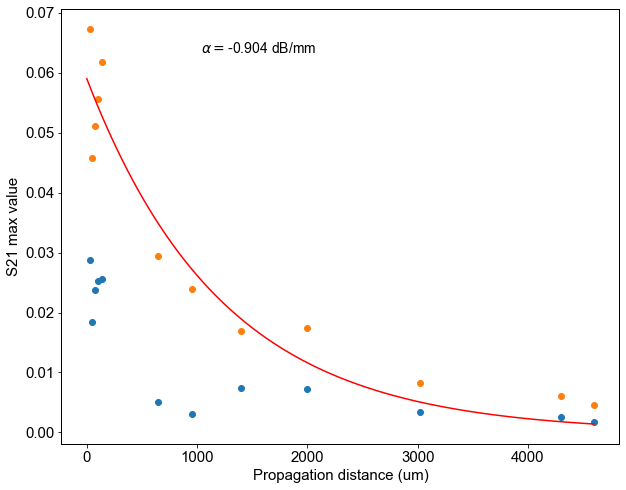

In [224]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# 30K

In [225]:
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[4:-12])

file_name = ['30K-*-S11-pol.prn', '30K-*-S22-pol.prn', '30K-*-S12-pol.prn', '30K-*-S21-pol.prn']
manual_idt_eff = np.array([0.31, 0.38, 0.41, 0.39, 0.36, 0.13, 0.11, 0.37, 0.36, 0.37, 0.36, 0.36 ])

freq11, freq21, S11_list_30K, S12_list_30K, S21_list_30K, S22_list_30K = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list_30K, S11_list_30K, S22_list_30K, N_FIT=11, manual_idt_eff=True, manual_idt_list = manual_idt_eff)
print(exp_popt_error)
S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.026137   0.02636398 0.02637114 0.0259256  0.02627698 0.02684559
 0.02621927 0.025912   0.02585146 0.02619956]
[0.02039635 0.02074503 0.02052172 0.02042888 0.02085229 0.02143979
 0.02094104 0.02044146 0.02050551 0.02087829]
[0.02186739 0.02221143 0.02200848 0.02228529 0.02227532 0.0226455
 0.02250734 0.02239027 0.02238876 0.02163654]
[0.0228047  0.02328927 0.02307164 0.02408651 0.0241846  0.02440871
 0.02350537 0.02439834 0.0239459  0.02376339]
[0.02406033 0.0250526  0.0248868  0.02516327 0.02531016 0.02597399
 0.02551368 0.02516811 0.02412962 0.02344115]
[0.00310242 0.00325421 0.00308861 0.00383379 0.0042789  0.00487554
 0.00450871 0.00383381 0.00276976 0.00229311]
[0.00185529 0.00197929 0.00143964 0.0024688  0.00202982 0.0

[0.026845587715242446, 0.02143978885657429, 0.022645500688185737, 0.024408710222125096, 0.025973991285297374, 0.004875537643856358, 0.0032824218599954704, 0.007253053073423617, 0.006155010441321184, 0.003471885602898222, 0.001827130457008436, 0.0015883925140736828]
[0.08571554 0.05498926 0.05474404 0.06213873 0.07053128 0.03513764
 0.02799832 0.01918259 0.01698298 0.00936227 0.00504949 0.00486427]
[0.08659867 0.0564205  0.05523293 0.06258644 0.07214998 0.03750414
 0.0298402  0.01960285 0.01709725 0.00938347 0.00507536 0.0044122 ]
0.05500425961977906
[0.07044442 0.8385994 ]


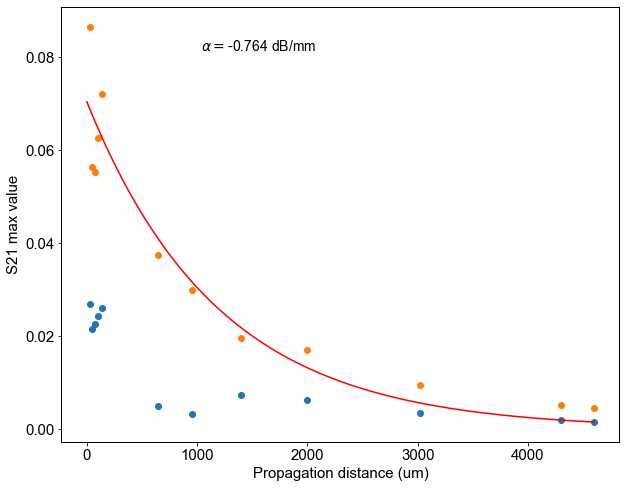

In [226]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# 40K

In [227]:
manual_idt_eff = np.array([0.09, 0.10, 0.10, 0.11, 0.11, 0.05, 0.048, 0.12, 0.10, 0.08, 0.11, 0.11 ])

file_name = ['40K-*-S11-pol.prn', '40K-*-S22-pol.prn', '40K-*-S12-pol.prn', '40K-*-S21-pol.prn']

freq11, freq21, S11_list, S12_list, S21_list, S22_list = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list, S11_list, S22_list,
                                                                                                             N_FIT=8, manual_idt_eff=True, manual_idt_list = manual_idt_eff, max_val_expend=2)
S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.02163772 0.0220357  0.02237707 0.02209072]
[0.01918243 0.01893561 0.01960984 0.01892781]
[0.01915957 0.01923309 0.0194868  0.01884357]
[0.02061993 0.02057185 0.02106907 0.02087647]
[0.02120969 0.02127821 0.02146525 0.02099759]
[0.00343152 0.00306799 0.00428397 0.00327499]
[0.00176453 0.00208919 0.00276828 0.0020758 ]
[0.00394924 0.00511092 0.00611973 0.00470495]
[0.0032402  0.00424147 0.00465842 0.00418659]
[0.00255675 0.002392   0.00278749 0.00160728]
[0.00148161 0.00110179 0.00207138 0.00183353]
[0.00064499 0.00077093 0.00146822 0.00109257]
L0 = 0.11906715076988396 nH
Rs = 10.244252421205376 Ohm
R0 = 100.61898915122718 Ohm
C0 = 0.0018876028443835459 nF
[20.]
L0 = 0.15504312625402872 nH
Rs = 1.8607097605833547 Ohm
R0 = 60.

[0.02237707250742092, 0.019609839345552174, 0.019486799321012105, 0.021069072217961612, 0.02146524931270752, 0.0042839654990337725, 0.0027682825671726955, 0.006119728015892653, 0.004658422552732344, 0.002787488368636142, 0.0020713833070427753, 0.0014682153253394632]
[0.26299378 0.18771588 0.17728063 0.18438148 0.19375639 0.07335974
 0.05678356 0.04888578 0.0519144  0.0247912  0.01635403 0.01038906]
[0.24863414 0.19609839 0.19486799 0.19153702 0.19513863 0.08567931
 0.05767255 0.05099773 0.04658423 0.0348436  0.01883076 0.01334741]
0.7589694952028114
[0.22741509 1.36712093]


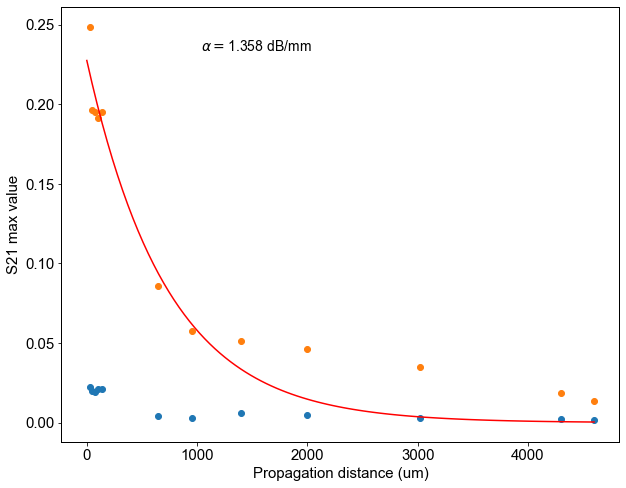

In [228]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# 60K

In [229]:
manual_idt_eff = np.array([0.03, 0.03, 0.03, 0.03, 0.02, 0.007, 0.007, 0.02, 0.02, 0.03, 0.03, 0.03 ])

file_name = ['60K-*-S11-pol.prn', '60K-*-S22-pol.prn', '60K-*-S12-pol.prn', '60K-*-S21-pol.prn']

freq11, freq21, S11_list, S12_list, S21_list, S22_list = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list, S11_list, S22_list, N_FIT=8,
                                                                                                             manual_idt_eff=True, manual_idt_list = manual_idt_eff,
                                                                                                             max_val_expend=2)
S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.01302924 0.01397821 0.01404345 0.01329337]
[0.01353198 0.01373196 0.01402532 0.01320707]
[0.0119134  0.01233044 0.01280036 0.01183817]
[0.01300343 0.01319939 0.01360138 0.01299609]
[0.01283902 0.01231881 0.01386457 0.01379628]
[0.00141782 0.00198358 0.00245351 0.00175883]
[0.00112602 0.00113919 0.00189532 0.00170035]
[0.0035138  0.00283453 0.00353035 0.00288673]
[0.00292116 0.00210574 0.00305597 0.00243621]
[0.0009593  0.00041548 0.00212998 0.00042384]
[0.00044391 0.00050132 0.00158154 0.00037615]
[0.00035966 0.00060041 0.0006037  0.00049675]
L0 = 0.17690461487624357 nH
Rs = 6.9131464958307145 Ohm
R0 = 158.3968915803866 Ohm
C0 = 0.0025968213794651746 nF
[20.]
L0 = 0.14522254966905762 nH
Rs = 1.8808359333405817 Ohm
R0 = 92.8

[0.014043454318715677, 0.014025322942522728, 0.012800363813998147, 0.013601384667170771, 0.013864567730361026, 0.00245350682847216, 0.0018953193880794997, 0.0035303507509215452, 0.0030559692029184897, 0.002129979068282181, 0.0015815399589488585, 0.0006036986278914174]
[0.40733795 0.647066   0.79632803 1.01554758 0.70551256 0.46717661
 0.23803627 0.14853126 0.1522993  0.09314317 0.0912889  0.03904008]
[0.46811514 0.46751076 0.42667879 0.45337949 0.69322839 0.35050098
 0.27075991 0.17651754 0.15279846 0.0709993  0.052718   0.02012329]
0.9138935087923136
[0.52358145 0.66415571]


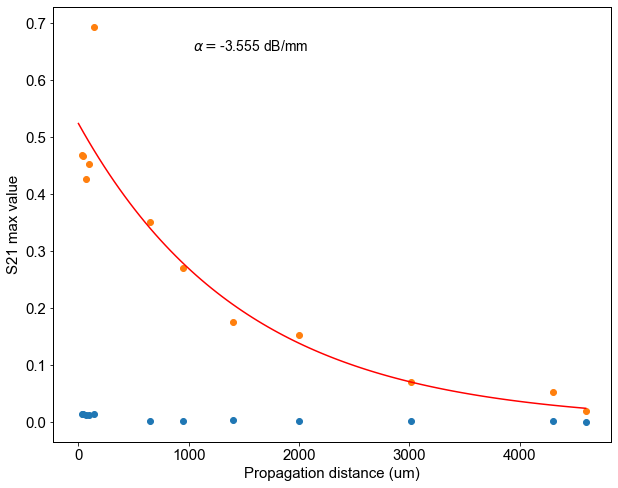

In [105]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# 70K

In [230]:
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[4:-12])
manual_idt_eff = np.array([0.03, 0.03, 0.03, 0.03, 0.02, 0.007, 0.007, 0.02, 0.02, 0.03, 0.03, 0.03 ])
file_name = ['70K-*-S11-pol.prn', '70K-*-S22-pol.prn', '70K-*-S12-pol.prn', '70K-*-S21-pol.prn']

freq11, freq21, S11_list, S12_list, S21_list, S22_list = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list, S11_list, S22_list,
                                                                                                             N_FIT=7, manual_idt_eff=True, manual_idt_list = manual_idt_eff,
                                                                                                             max_val_expend=1)
S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.0141641  0.01493368]
[0.01307506 0.01383419]
[0.01077322 0.01140662]
[0.01196041 0.01302272]
[0.01182489 0.01240035]
[0.00199824 0.00242743]
[0.00095852 0.00160327]
[0.00292641 0.0029293 ]
[0.00253263 0.0026398 ]
[0.00087752 0.00190412]
[0.00073353 0.00174715]
[0.00053355 0.00157336]
L0 = 0.1785277879889548 nH
Rs = 7.232781585738169 Ohm
R0 = 155.32252039027398 Ohm
C0 = 0.002615501728995765 nF
[20.]
L0 = 0.1453185993817258 nH
Rs = 1.8649279369417182 Ohm
R0 = 88.20764799520252 Ohm
C0 = 0.005404142601780129 nF
[6.99385441]
L0 = 0.17865815183857423 nH
Rs = 7.397544403717278 Ohm
R0 = 172.6526499267956 Ohm
C0 = 0.002535826283347227 nF
[19.99999999]
L0 = 0.13612033992904768 nH
Rs = 1.7187697642515085 Ohm
R0 = 85.84300454767111 Ohm

[0.014933677104145024, 0.013834187457216039, 0.011406615642928148, 0.013022715238687534, 0.01240034546294703, 0.0024274322976731264, 0.0016032720244914416, 0.0029292981424016195, 0.0026398042872182448, 0.001904119536378346, 0.0017471546525795103, 0.0015733577579126337]
[0.48149289 0.57477243 0.65553605 1.09617354 0.78325533 0.62112707
 0.22445469 0.17766271 0.15463737 0.1067496  0.15232633 0.13479582]
[0.49778924 0.46113958 0.38022052 0.43409051 0.62001727 0.34677604
 0.22903886 0.14646491 0.13199021 0.06347065 0.05823849 0.05244526]
0.8621608297608145
[0.50062217 0.6618535 ]


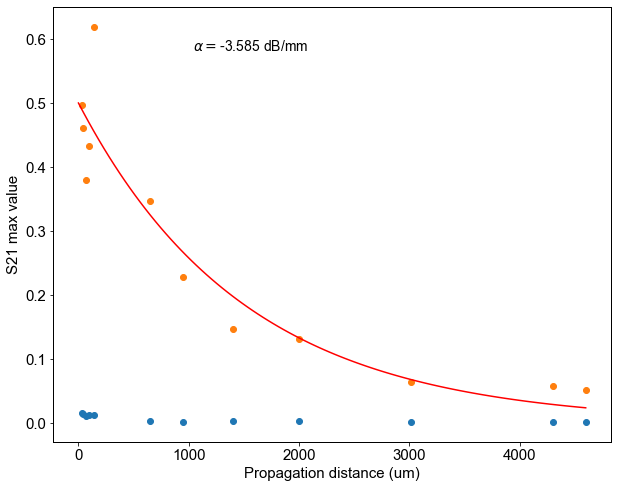

In [231]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# 95K

In [232]:
manual_idt_eff = np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.007, 0.007, 0.02, 0.02, 0.03, 0.03, 0.03 ])
file_name = ['95K-*-S11-pol.prn', '95K-*-S22-pol.prn', '95K-*-S12-pol.prn', '95K-*-S21-pol.prn']

freq11, freq21, S11_list, S12_list, S21_list, S22_list = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list, S11_list, S22_list,
                                                                                                             N_FIT=6, manual_idt_eff=True, manual_idt_list = manual_idt_eff,
                                                                                                             max_val_expend=1)
S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.01328471 0.01360615]
[0.01244255 0.01258813]
[0.00904273 0.00982735]
[0.01052546 0.0116408 ]
[0.01045298 0.01108575]
[0.00122922 0.00181146]
[0.00040586 0.00167358]
[0.00225502 0.00295128]
[0.00111091 0.00208633]
[0.00103997 0.00158088]
[0.00025671 0.00146667]
[0.00035954 0.00049617]
L0 = 0.16394279755902746 nH
Rs = 6.7044915744256235 Ohm
R0 = 157.48402794886505 Ohm
C0 = 0.0026467884602787476 nF
[20.]
L0 = 0.13925907977170418 nH
Rs = 1.8309261066229348 Ohm
R0 = 92.27532064942883 Ohm
C0 = 0.005513385019967278 nF
[6.20764579]
L0 = 0.17349356429978469 nH
Rs = 8.009961146675186 Ohm
R0 = 175.6937749605745 Ohm
C0 = 0.002553498187204185 nF
[19.9999986]
L0 = 0.13169531370781043 nH
Rs = 1.7047360188151546 Ohm
R0 = 89.04193299747718 

[0.013606145908847992, 0.012588125414904465, 0.009827346620646693, 0.011640796620033358, 0.011085750389517118, 0.0018114594381844254, 0.0016735835903141537, 0.002951277331023143, 0.0020863273050557665, 0.0015808843102925905, 0.0014666652601851593, 0.0004961724030768403]
[0.42911322 0.48661013 0.41086823 0.74266936 0.66491903 0.55700161
 0.27724036 0.15821362 0.11144501 0.0955399  0.12502059 0.04037049]
[0.4535382  0.41960418 0.32757822 0.38802655 0.36952501 0.25877992
 0.23908337 0.14756387 0.10431637 0.05269614 0.04888884 0.01653908]
0.8725837306631592
[0.41692519 0.77564869]


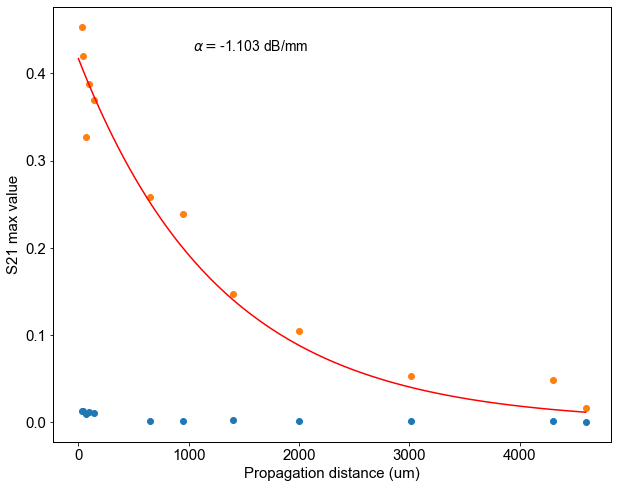

In [233]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# 140K

In [234]:
manual_idt_eff = np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.007, 0.007, 0.02, 0.02, 0.03, 0.03, 0.03 ])

def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[5:-12])

file_name = ['140K-*-S11-pol.prn', '140K-*-S22-pol.prn', '140K-*-S12-pol.prn', '140K-*-S21-pol.prn']

freq11, freq21, S11_list, S12_list, S21_list, S22_list = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list, S11_list, S22_list, N_FIT=5,
                                                                                                             manual_idt_eff=True, manual_idt_list = manual_idt_eff,
                                                                                                             max_val_expend=1)
S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.01423825 0.01461843]
[0.01457464 0.01527036]
[0.01068998 0.01072625]
[0.01191554 0.01261705]
[0.01180851 0.01237092]
[0.00069089 0.00221107]
[0.00070949 0.00175895]
[0.00197901 0.00264436]
[0.00097345 0.00162656]
[0.00048215 0.00150342]
[9.95601592e-05 1.65060980e-03]
[9.09439554e-05 1.51270192e-03]
L0 = 0.13990876011122624 nH
Rs = 8.050099126520374 Ohm
R0 = 129.3591188431745 Ohm
C0 = 0.0026385094386419798 nF
[19.99999994]
L0 = 0.1384831114835401 nH
Rs = 2.304491142784896 Ohm
R0 = 79.2789101855025 Ohm
C0 = 0.005533510476675041 nF
[6.00000004]
L0 = 0.13962390191531876 nH
Rs = 7.919345849449117 Ohm
R0 = 139.23116891617897 Ohm
C0 = 0.0025377659302646036 nF
[20.]
L0 = 0.12851242623952971 nH
Rs = 2.1867279877296406 Ohm
R0 = 74.3

[0.014618429542896574, 0.015270364493039142, 0.010726250739253228, 0.01261705313079407, 0.012370920904494705, 0.0022110684232553635, 0.0017589475581207947, 0.0026443618261581285, 0.001626557585960444, 0.0015034179131469753, 0.0016506098037969577, 0.0015127019248958504]
[0.48010106 0.48757123 0.3701828  0.53632754 0.68204386 0.66148927
 0.31943444 0.12578582 0.08309999 0.07798605 0.08506921 0.04961389]
[0.48728098 0.50901215 0.35754169 0.42056844 0.41236403 0.31586692
 0.25127822 0.13221809 0.08132788 0.05011393 0.05502033 0.0504234 ]
0.21224205995845447
[0.50474258 1.89892694]


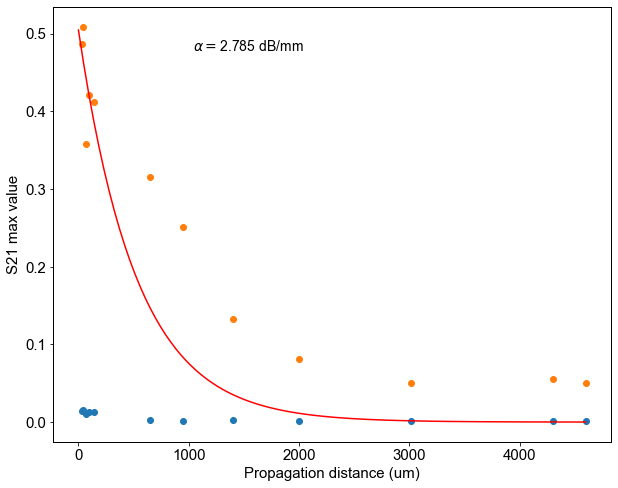

In [235]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# 210 K

In [112]:
manual_idt_eff = np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.007, 0.007, 0.02, 0.02, 0.03, 0.03, 0.03 ])

file_name = ['210K-*-S11-pol.prn', '210K-*-S22-pol.prn', '210K-*-S12-pol.prn', '210K-*-S21-pol.prn']

freq11, freq21, S11_list, S12_list, S21_list, S22_list = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list, S11_list, S22_list,
                                                                                                             N_FIT=4, manual_idt_eff=True, manual_idt_list = manual_idt_eff,
                                                                                                             max_val_expend=1)
S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.01539575 0.01592743]
[0.01740586 0.01886768]
[0.01359057 0.01408166]
[0.01349043 0.01447072]
[0.01405872 0.01472226]
[0.00025087 0.0019429 ]
[0.00044808 0.00157959]
[0.00109352 0.00235125]
[0.00014184 0.00153719]
[0.00095347 0.00149091]
[0.00041328 0.00140649]
[7.61441783e-05 1.48522334e-03]
L0 = 0.12070247065122709 nH
Rs = 8.924045789634862 Ohm
R0 = 98.8728647168044 Ohm
C0 = 0.0024102247062599428 nF
[19.93053885]
L0 = 0.13284511878648 nH
Rs = 2.7298612024893023 Ohm
R0 = 59.014654384630894 Ohm
C0 = 0.005085473655204895 nF
[6.15637567]
L0 = 0.11560559939477565 nH
Rs = 9.05602394211542 Ohm
R0 = 98.6380774858715 Ohm
C0 = 0.0022102612643050074 nF
[19.99996516]
L0 = 0.12747172479576158 nH
Rs = 2.686612031277099 Ohm
R0 = 56.92734

[0.014618429542896574, 0.015270364493039142, 0.010726250739253228, 0.01261705313079407, 0.012370920904494705, 0.0022110684232553635, 0.0017589475581207947, 0.0026443618261581285, 0.001626557585960444, 0.0015034179131469753, 0.0016506098037969577, 0.0015127019248958504]
[0.48010106 0.48757123 0.3701828  0.53632754 0.68204386 0.66148927
 0.31943444 0.12578582 0.08309999 0.07798605 0.08506921 0.04961389]
[0.48728098 0.50901215 0.35754169 0.42056844 0.41236403 0.31586692
 0.25127822 0.13221809 0.08132788 0.05011393 0.05502033 0.0504234 ]
0.21224205995845447
[0.50474258 1.89892694]


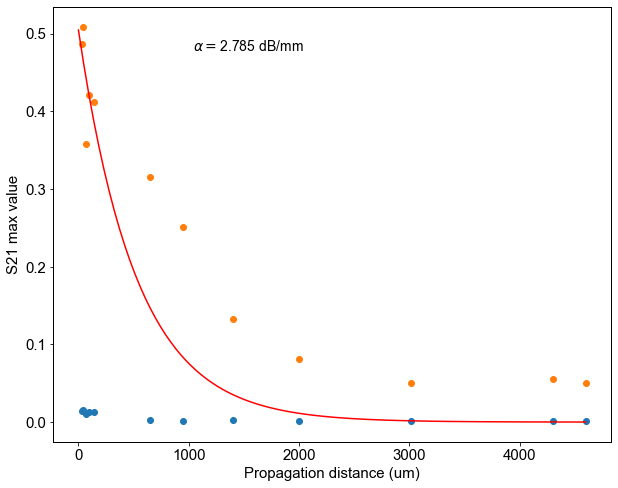

In [236]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# RT

In [237]:
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[3:-12])

manual_idt_eff = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ])

file_name = ['RT-*-S11-pol.prn', 'RT-*-S22-pol.prn', 'RT-*-S12-pol.prn', 'RT-*-S21-pol.prn']

freq11, freq21, S11_list, S12_list, S21_list, S22_list = import_data(file_names=file_name , DL_dir_name=DL_dir_name)

S21_max_list, S21_avg_list, S21_errorbar_list, norm_s21, idt_eff_list, exp_popt, exp_popt_error = get_alpha(freq11, freq21, S21_list, S11_list, S22_list,
                                                                                                             N_FIT=6, manual_idt_eff=True, manual_idt_list = manual_idt_eff,
                                                                                                             max_val_expend=1)

S22_list_RT = S22_list
norm_s21_RT = norm_s21
norm_s21_RT_errorbar = S21_errorbar_list
exp_popt_RT = exp_popt

S21_max_export.append(S21_max_list)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
[0.01026725 0.01118022]
[0.01438917 0.01511621]
[0.00894174 0.00990705]
[0.008249  0.0094728]
[0.00865518 0.00897982]
[0.00039574 0.00137989]
[5.40924611e-05 1.61353377e-03]
[0.00048206 0.00150156]
[0.00021809 0.00150524]
[0.00045374 0.00175491]
[0.00091277 0.00153988]
[0.00044211 0.0015189 ]
L0 = 0.010000000007480515 nH
Rs = 12.238614127617687 Ohm
R0 = 78.57909394555679 Ohm
C0 = 0.0017275074997326954 nF
[20.]
L0 = 0.1095842956689668 nH
Rs = 5.60329108480054 Ohm
R0 = 54.84326576853674 Ohm
C0 = 0.004541695061112592 nF
[24.35055741]
L0 = 0.010000000082617968 nH
Rs = 12.236226666701478 Ohm
R0 = 83.17994774889117 Ohm
C0 = 0.0016755220670880832 nF
[20.]
L0 = 0.10500274275829469 nH
Rs = 5.301926809730244 Ohm
R0 = 54.201310312198615 

[0.0111802226985341, 0.015116211181288254, 0.00990705117021953, 0.009472798569882647, 0.008979816446502887, 0.0013798857534246711, 0.001613533773308476, 0.0015015630808745167, 0.0015052383546918587, 0.001754910268126205, 0.0015398784410822143, 0.001518903741471344]
[2.79773555 3.69711839 2.28106012 1.36312897 0.93171227 0.07553625
 0.18543749 0.17707216 0.17903047 0.2061623  0.22881692 0.30649606]
[0.01118022 0.01511621 0.00990705 0.0094728  0.00897982 0.00137989
 0.00161353 0.00150156 0.00150524 0.00175491 0.00153988 0.0015189 ]
0.29691344179925583
[0.0142756  3.59460773]


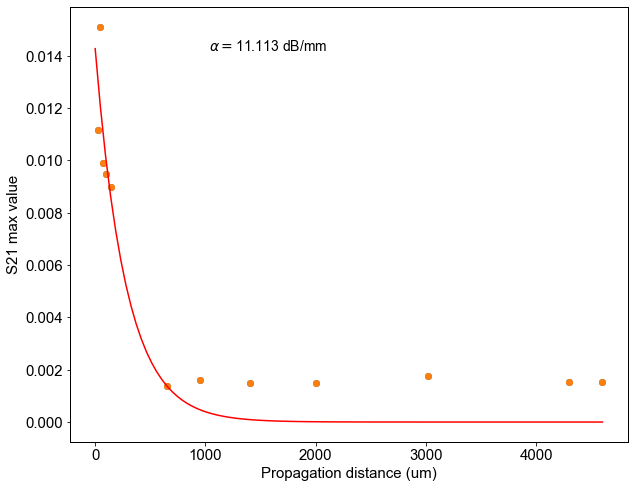

In [115]:
print(S21_max_list)
print(S21_max_list/idt_eff_list)
print(norm_s21)

alpha_decay = -10*np.log10(exp_popt[1]) # Unit in dB/mm
x_fit = np.linspace(0, prop_distance[-1], 100)

# Plot the fit
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(prop_distance, S21_max_list, 'o')
ax.plot(prop_distance, norm_s21, 'o')
ax.plot(x_fit, exp_decay(np.array(x_fit)*1e-3, *exp_popt), 'r-')

ax.set_xlabel('Propagation distance (um)')
ax.set_ylabel('S21 max value')

# Show the loss constant in the plot
ax.text(0.25, 0.9, r'$\alpha = $' + str(np.round(20*np.log10(exp_popt[1]), 3)) + ' dB/mm', transform=ax.transAxes, fontsize=14)
print(exp_popt_error)
print(exp_popt)

# Temp-dep loss

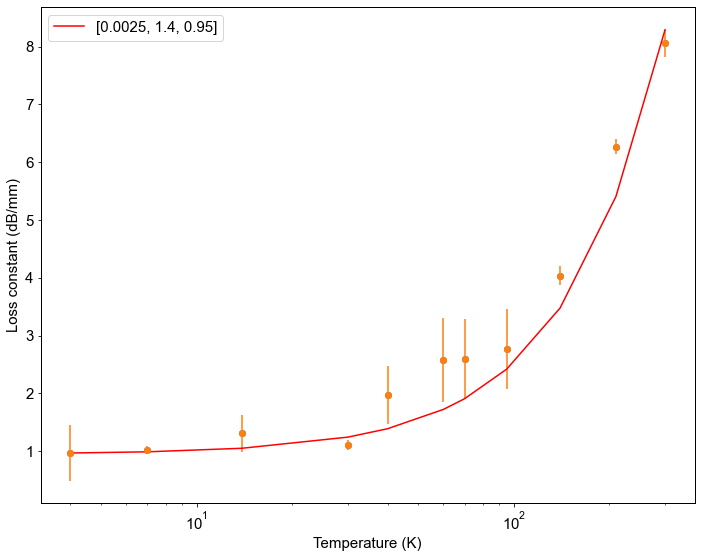

In [261]:
lost_list = np.array([0.67, 0.705, 0.904, 0.764, 1.358, 1.777, 1.792, 1.911, 2.785, 4.324, 5.557 ]) *1.45   #dB/mm
lost_err = np.array([0.6, 0.074, 0.4, 0.11, 0.62, 0.91, 0.86, 0.87, 0.21, 0.16, 0.29]) *0.8
T_list =    [4, 7, 13.9, 30, 40, 60, 70, 95, 140, 210, 300] # K

def temp_fit(x, a, b, c):
    return a*(x)**b + c 

popt, pcov = curve_fit(temp_fit, T_list, 10**(np.array(lost_list)/10))

popt = [25e-4, 1.4, 0.95]

# Plot lost_list versus T_list
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(T_list, lost_list, 'o')
ax.errorbar(T_list, lost_list, yerr=lost_err, fmt='o')
ax.plot(T_list, temp_fit(np.array(T_list), *popt), 'r-', label=str(popt))
ax.set_xscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Loss constant (dB/mm)')
ax.legend()
fig.tight_layout()

In [262]:
T_depend_lost_export = np.array([T_list, lost_list, lost_err])
np.savetxt('T_depend_lost_export.csv', T_depend_lost_export, delimiter=',')

In [53]:
# Export S21_max_list_export as a csv file
S21_max_export = np.array(S21_max_export)
np.savetxt('S21_max_list_export.csv', S21_max_export, delimiter=',')

# AOFS data

In [54]:
import numpy as np

def moving_average(x_data, y_data, window_size, break_start, break_end):
    """
    Calculates the moving average of a 1D array using a specified window size.
    
    Parameters:
    -----------
    data : numpy.ndarray
        1D array of data to calculate the moving average on.
    window_size : int
        Size of the moving average window.
    break_start : int
        Start of the break in the data. (The data that does not need to be averaged)
    break_end : int
        End of the break in the data. (The data that does not need to be averaged)
        
    Returns:
    --------
    numpy.ndarray
        1D array of the moving average of the input data.
    """
    indx_break_start = np.argmin(np.abs(x_data-break_start))
    indx_break_end = np.argmin(np.abs(x_data-break_end))

    # Pad the data array with NaNs on either end to handle edge cases
    padded_data = np.pad(y_data, window_size // 2, mode='constant', constant_values=np.nan)
    
    # Calculate the moving average using a convolution with a boxcar window
    boxcar = np.ones(window_size) / window_size
    ma_before = np.convolve(padded_data[0:indx_break_start], boxcar, mode='valid')
    ma_after = np.convolve(padded_data[indx_break_end:], boxcar, mode='valid')
    ma = np.concatenate((ma_before, y_data[indx_break_start:indx_break_end], ma_after))
    
    return ma


In [55]:
import pandas as pd

# set the data path
p_name =  root_path + '/20230227-AOFS5_Origina export data//'
f_name = '6G.csv'

# read the Excel file and store the data in a Pandas DataFrame
df = pd.read_csv(p_name+f_name)

# print the column of the DataFrame
print('Headers are: ') 
for n in list(df.columns):
    print(n) 
    
# extract the combined frequency
freq = df['Combine Frequency'].tolist() 
AS = df['Anti-Stokes'].tolist() 
S = df['Stokes'].tolist() 

Headers are: 
Central 6.55G, Span 75MHz, Resolution 320001 points
Combine Frequency
Anti-Stokes
Stokes
Unnamed: 4
Unnamed: 5
Unnamed: 6


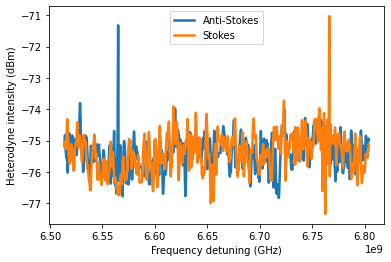

In [56]:
# Smooth the AS and S data
from scipy.signal import savgol_filter
window_size = 600
start1, end1 = 6.56e9, 6.57e9
start2, end2 = 6.76e9, 6.77e9
freq = np.array(freq)

AS_f = moving_average(freq, AS, window_size, start1, end1)
S_f = moving_average(freq, S, window_size, start2, end2)

#plt.plot(freq, AS, label='Anti-Stokes', color='red')
plt.plot(freq[int(window_size/2)-1:-(int(window_size/2)-1)], AS_f, linewidth=2.5, label='Anti-Stokes')
plt.plot(freq[int(window_size/2)-1:-(int(window_size/2)-1)], S_f-0.5, linewidth=2.5, label='Stokes')
plt.ylabel('Heterodyne intensity (dBm)')
plt.xlabel('Frequency detuning (GHz)')
plt.legend()

# Combined plot

In [57]:

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rcParams["font.weight"] = "normal"
matplotlib.rcParams["axes.labelweight"] = "normal"
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42

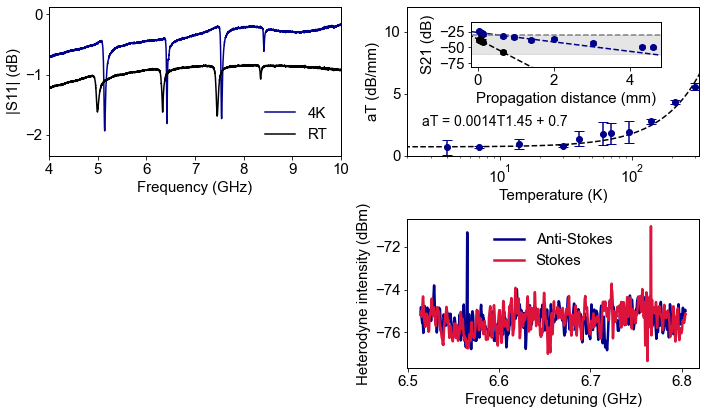

In [64]:
# Plot a 2 by 4 grid with the first 2 plot as placeholder
fig = plt.figure(figsize=(20, 6))
ax1 = plt.subplot2grid((2,4), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2,4), (0, 1), colspan=1)
ax3 = plt.subplot2grid((2,4), (1, 1), colspan=1)

# S11 plot----------------------------------------------------------------------------
ax1.plot(freq11/1e9, 10*np.log10(abs(S22_list_4K[3])), label='4K', color ='darkblue')
ax1.plot(freq11/1e9, 10*np.log10(abs(S22_list_RT[1])), label='RT', color = 'black')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('|S11| (dB)')
# Set legend without box
ax1.set_xlim(4,10)
ax1.legend(frameon=False)

# S21 plot----------------------------------------------------------------------------
T_fit = np.linspace(0, 400, 100)
ax2.errorbar(T_list, lost_list, yerr=lost_err, fmt='o', capsize=5, color = 'darkblue')
ax2.plot(T_fit, temp_fit(np.array(T_fit), *popt), '--', label='fit: a=%5.3f' % popt[0], color = 'black')
ax2.text(0.05, 0.2, r'aT = ' + str(np.round(popt[0], 4))+'T1.45' + ' + ' + str(abs(np.round(popt[2], 2))), transform=ax2.transAxes, fontsize=14)
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel(r'aT (dB/mm)')
ax2.set_ylim(0, 12)
ax2.set_xscale('log')
ax2.set_xlim(2,320)

# Plot a inset in axs[0,3] and set the location of the inset by coordinates
axins = ax2.inset_axes([0.22, 0.60, 0.65, 0.3])
axins.errorbar(np.array(prop_distance)/1e3, 20*np.log10(norm_s21_4K), yerr=np.log10(np.abs(norm_s21_4K_errorbar)), fmt='o', capsize=3, color = 'darkblue')
axins.errorbar(np.array(prop_distance[:6])/1e3, 20*np.log10(norm_s21_RT[:6]), yerr=np.log10(np.abs(norm_s21_RT_errorbar[:6])), fmt='o', capsize=3, color = 'black')
axins.plot(x_fit/1e3, 20*np.log10(exp_decay(np.array(x_fit)*1e-3, *exp_popt_4K)), '--', color = 'darkblue')
axins.plot(x_fit/1e3, 20*np.log10(exp_decay(np.array(x_fit)*1e-3, *exp_popt_RT)), '--', color = 'black')

# Fill the area less than -30 dB
x_fit = np.linspace(-1000, prop_distance[-1]+200, 100)
axins.fill_between(x_fit/1e3, -30, -60, alpha=0.2, color='grey')
axins.plot(x_fit/1e3, -30*np.ones(len(x_fit)), '--', color='grey')

axins.set_ylim(-80, -10)
axins.set_xlim(np.array(prop_distance[0])/1e3 - 0.2, np.array(prop_distance[-1])/1e3 + 0.2)
axins.set_xlabel('Propagation distance (mm)')
axins.set_ylabel('S21 (dB)')

# AOFS plot----------------------------------------------------------------------------
#plt.plot(freq, AS, label='Anti-Stokes', color='red')
ax3.plot(freq[int(window_size/2)-1:-(int(window_size/2)-1)]/1e9, AS_f, linewidth=2.5, label='Anti-Stokes', color='darkblue')
ax3.plot(freq[int(window_size/2)-1:-(int(window_size/2)-1)]/1e9, S_f-0.5, linewidth=2.5, label='Stokes', color ='crimson')
ax3.set_ylabel('Heterodyne intensity (dBm)')
ax3.set_xlabel('Frequency detuning (GHz)')
ax3.legend(frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('Acoustics.pdf', dpi=300, bbox_inches='tight')

In [61]:
# Export all the relevent data of this plot

S11_RT_export = np.array([freq11, S22_list_RT[1].real, S22_list_RT[1].imag])
S11_4K_export = np.array([freq11, S22_list_4K[3].real, S22_list_4K[3].imag])
T_depend_lost_export = np.array([T_list, lost_list, lost_err])
prop_distance_RT_export = np.array([prop_distance, norm_s21_4K, norm_s21_4K_errorbar])
prop_distance_4K_export = np.array([prop_distance[:6], norm_s21_RT[:6], norm_s21_RT_errorbar[:6]])

# AOFS export
freq_export = freq[int(window_size/2)-1:-(int(window_size/2)-1)]
AS_export = np.array([freq_export, AS_f])
S_export = np.array([freq_export, S_f-0.5])

# Save the data for all exports
np.savetxt('S11_RT_export.csv', S11_RT_export, delimiter=',')
np.savetxt('S11_4K_export.csv', S11_4K_export, delimiter=',')
np.savetxt('T_depend_lost_export.csv', T_depend_lost_export, delimiter=',')
np.savetxt('prop_distance_RT_export.csv', prop_distance_RT_export, delimiter=',')
np.savetxt('prop_distance_4K_export.csv', prop_distance_4K_export, delimiter=',')
np.savetxt('AS_export.csv', AS_export, delimiter=',')
np.savetxt('S_export.csv', S_export, delimiter=',')


# Supporting figures

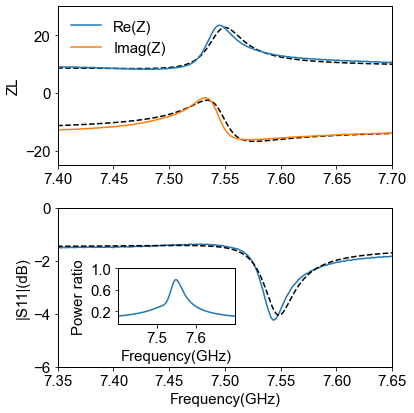

In [60]:

fig = plt.figure(figsize=(6,6))
ax3 = plt.subplot(211)
ax4 = plt.subplot(212)

ax3.plot(freq_sup/1e9, (Z_fit_sup).real, "--", color = 'black')
ax3.plot(freq_sup/1e9, Z_sup.real, label = 'Re(Z)')
ax3.plot(freq_sup/1e9, (Z_fit_sup).imag, "--", color = 'black')
ax3.plot(freq_sup/1e9, Z_sup.imag, label = 'Imag(Z)')
ax3.set_xlim(7.4, 7.7)
ax3.set_ylim(-25,30)
ax3.set_ylabel('ZL')
ax3.legend(frameon=False)

ax4.plot(freq_sup/1e9, 10*np.log10(abs(S11_data_sup)) )
ax4.plot(freq_sup/1e9, 10*np.log10(abs(S11_fit_sup)), "--", color = "black")
ax4.set_xlim(7.35, 7.65)
ax4.set_ylim(-6,0)
ax4.set_ylabel('|S11|(dB)')
ax4.set_xlabel('Frequency(GHz)')

# add a inset in ax4
axins = ax4.inset_axes([0.18, 0.27, 0.35, 0.35])
axins.plot(freq_sup/1e9, abs(Pwr_YN_list_sup[0]), label = 'Y')
axins.set_xlim(7.4, 7.7)
axins.set_yticks([0.2,  0.6,  1.0])
axins.set_xticks([7.5, 7.6])
axins.set_xlabel('Frequency(GHz)')
axins.set_ylabel('Power ratio')

fig.tight_layout()

# Save the figure
#fig.savefig('BVD.pdf', dpi=300, bbox_inches='tight')

## Time gating supporting

In [211]:
dev_numbers = [0,1,2]

t_span_supp = []
filtered_ift_data_supp = []
org_ift_data_supp = []
freq21_supp = []
org_s21_supp = []
filtered_s21_supp = []

for dev_number in dev_numbers:
    N_pts, s21_ift, t_span, t_reso = ifft_complex_data(S21_list_4K[dev_number], freq21, print_time_reso = False)
    _, nor_cmpl_filtered, t_span, filtered_ift_data, org_ift_data = Filter_S21_signals(   freq22,
                                                                                            s21_ift, 
                                                                                            t_reso,   
                                                                                            N_pts = len(S21_list_4K[0]),  
                                                                                            filter_noise = True,
                                                                                            filter_peaks = False,
                                                                                            filter_picking = False, 
                                                                                            filter_stop = True,
                                                                                            t_noise=[1], expand_noise = 0.1,
                                                                                            t_peaks=[0], expand_peaks = 200,
                                                                                            t_picked = [0], expand_picked = 20,
                                                                                            t_stop = 1300,
                                                                                            xmax=200, ymax=200e-6, ymax_fdom = 10e-5, manual_scale= False,
                                                                                            savefig = False,
                                                                                            plot_filtering = False)

    # Time domain data for supporting
    t_span_supp.append(t_span)
    filtered_ift_data_supp.append(filtered_ift_data)
    org_ift_data_supp.append(org_ift_data)
    # Frequency domain data for supporting
    freq21_supp.append(freq21)
    org_s21_supp.append(S21_list_4K[dev_number])
    filtered_s21_supp.append(nor_cmpl_filtered)

t_span_supp = np.array(t_span_supp)
filtered_ift_data_supp = np.array(filtered_ift_data_supp)
org_ift_data_supp = np.array(org_ift_data_supp)

freq21_supp = np.array(freq21_supp)
org_s21_supp = np.array(org_s21_supp)
filtered_s21_supp = np.array(filtered_s21_supp)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...


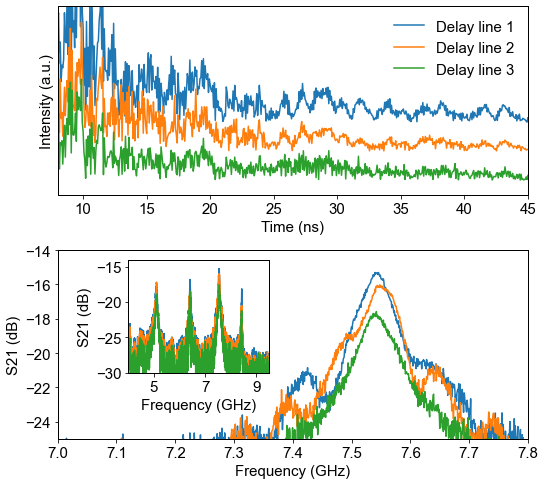

In [217]:
# Plotting the time gating data
fig = plt.figure(figsize=(8,7))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

for t_ss, org_ss, num_ss in zip(t_span_supp, org_ift_data_supp, dev_numbers):
    ax1.plot(t_ss*1e9, abs(org_ss) - 8e-5*num_ss, label = "Delay line " + str(num_ss+1))
ax1.set_ylabel('Intensity (a.u.)')
ax1.set_xlabel('Time (ns)')
ax1.legend(frameon=False)
ax1.set_ylim(-2e-4, 8*max(abs(org_ift_data_supp[1][1000:5000])))
ax1.set_xlim(8, 45)
ax1.set_yticks([])

for f_ss, fil_ss, num_ss in zip(freq21_supp, filtered_s21_supp, dev_numbers):
    ax2.plot(f_ss/1e9, 10*np.log10(abs(fil_ss)) , label = "Device " + str(num_ss+1))

ax2.set_xlim(7,7.8)
ax2.set_ylim(-25,-14)
ax2.set_ylabel('S21 (dB)')
ax2.set_xlabel('Frequency (GHz)')

# plot a inset in ax2
axins = ax2.inset_axes([0.15, 0.35, 0.30, 0.60])
for f_ss, fil_ss, num_ss in zip(freq21_supp, filtered_s21_supp, dev_numbers):
    axins.plot(f_ss/1e9, 10*np.log10(abs(fil_ss)) , label = "Device " + str(num_ss))
axins.set_xlim(4, 9.5)
axins.set_ylim(-30, -14)
axins.set_xlabel('Frequency (GHz)')
axins.set_ylabel('S21 (dB)')
axins.set_xticks([5, 7, 9])
axins.set_yticks([-30, -25, -20, -15])

# Adjust layout
plt.tight_layout()
fig.savefig('Gating.pdf', dpi=300, bbox_inches='tight')


0.008571428571428572